## 2/4/2026

In [22]:
import sys
sys.path.append('/Users/iemotoyuni/Desktop/SpenderQ/SpenderQ_Clone/SpenderQ/src')

from spenderq.spenderq import SpenderQ
from spenderq import desi_qso
import torch
import numpy as np
import pandas as pd
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io.fibermap import read_fibermap
from astropy.table import Table, vstack
import glob
import os

In [41]:
desiQSO = desi_qso.DESI()


## open qso_catalog 

In [23]:
filepath = "/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/QSO_cat_iron_cumulative_v0.fits"

with fits.open(filepath) as hdul:
    for i, hdu in enumerate(hdul):
        print(f"\n--- Header for HDU {i} ---")
        print(hdu.header)

# Load FITS table
with fits.open(filepath) as hdul:
    data = hdul[1].data

df = pd.DataFrame(data)

df

qsos = Table.read(filepath)



--- Header for HDU 0 ---
SIMPLE  =                    T / conforms to FITS standard                      BITPIX  =                    8 / array data type                                NAXIS   =                    0 / number of array dimensions                     EXTEND  =                    T                                                  END                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

In [3]:
print(df[['TARGETID', 'TILEID', 'LASTNIGHT']])


# ======= Check multiple TARGETIDs =======
target_ids_to_check = [39627859723032583, 39628488923152527]  # Add or modify TARGETIDs here

for target_id in target_ids_to_check:
    result = df[df['TARGETID'] == target_id]
    if len(result) > 0:
        print(f"\n✓ TARGETID {target_id} found:")
        print(f"  TILEID values: {result['TILEID'].values}")
        print(f"  Z (redshift): {result['Z'].values[0]:.6f}")
        print(f"  LASTNIGHT: {result['LASTNIGHT'].values[0]}")
    else:
        print(f"\n✗ TARGETID {target_id} not found in catalog")

                  TARGETID  TILEID  LASTNIGHT
0        39628488923152527   80615   20201216
1        39628483692860311   80615   20201216
2        39628488918960626   80615   20201216
3        39628483692857098   80615   20201216
4        39628488923152946   80615   20201216
...                    ...     ...        ...
2182304  39633411484160756   23644   20220613
2182305  39633411484159101   23644   20220613
2182306  39633402852283800   23644   20220613
2182307  39633402856473475   23644   20220613
2182308  39633391003371313   23644   20220613

[2182309 rows x 3 columns]

✓ TARGETID 39627859723032583 found:
  TILEID values: [80609     1     2     6     8  8772  5633]
  Z (redshift): 2.648059
  LASTNIGHT: 20201217

✓ TARGETID 39628488923152527 found:
  TILEID values: [80615]
  Z (redshift): 0.404274
  LASTNIGHT: 20201216


In [93]:
# Display TARGETIDs in TILEID 80615
tile_id_80615 = 80615
tile_df_80615 = df[df['TILEID'] == tile_id_80615]
print(f"\nTARGETIDs in TILEID {tile_id_80615}:")
print(tile_df_80615[['TARGETID', 'TILEID', 'LASTNIGHT']])


TARGETIDs in TILEID 80615:
              TARGETID  TILEID  LASTNIGHT
0    39628488923152527   80615   20201216
1    39628483692860311   80615   20201216
2    39628488918960626   80615   20201216
3    39628483692857098   80615   20201216
4    39628488923152946   80615   20201216
..                 ...     ...        ...
335  39628494145064856   80615   20201216
336  39628488927350127   80615   20201216
337  39628483701248756   80615   20201216
338  39628488927349424   80615   20201216
339  39628488931542332   80615   20201216

[340 rows x 3 columns]


## Just coadd-0-10256-thru20211110.fits


In [5]:
# ========== Load DESI Cumulative Coadd Spectra & Redshifts ==========
spec_file = '/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/cumulative/10256/20211110/coadd-0-10256-thru20211110.fits'
cat_file = '/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/QSO_cat_iron_cumulative_v0.fits'

# Load all three bands (B, R, Z) from cumulative coadd
bands = {}
with fits.open(spec_file) as hdul:
    for band in ['B', 'R', 'Z']:
        bands[band] = {
            'wavelength': np.array(hdul[f'{band}_WAVELENGTH'].data, dtype=np.float32),
            'flux_raw': np.array(hdul[f'{band}_FLUX'].data, dtype=np.float32),  # (Nfiber, Nwave)
            'ivar_raw': np.array(hdul[f'{band}_IVAR'].data, dtype=np.float32),  # (Nfiber, Nwave)
        }
    fibermap = hdul['FIBERMAP'].data

print(f'Band info:')
for band in ['B', 'R', 'Z']:
    print(f' {band}: wavelength shape {bands[band]["wavelength"].shape}, flux shape {bands[band]["flux_raw"].shape}')

# Select first 10 spectra for all bands
Nspec = 10
for band in ['B', 'R', 'Z']:
    bands[band]['flux'] = bands[band]['flux_raw'][:Nspec]
    bands[band]['ivar'] = bands[band]['ivar_raw'][:Nspec]

# Get TARGETIDs and redshifts from QSO catalog
targetids_in_fiber = fibermap['TARGETID'][:Nspec]
with fits.open(cat_file) as hdul:
    qso_data = hdul['QSO_CAT'].data
    qso_targetids = qso_data['TARGETID']
    qso_z = qso_data['Z']
    
    # Match TARGETIDs to get redshifts
    z_values = np.zeros(Nspec, dtype=np.float32)
    for i, tid in enumerate(targetids_in_fiber):
        idx = np.where(qso_targetids == tid)[0]
        if len(idx) > 0:
            z_values[i] = qso_z[idx[0]]

print(f'Loaded {Nspec} spectra')
print(f'Redshifts: min={z_values.min():.3f}, max={z_values.max():.3f}, mean={z_values.mean():.3f}')

# Set current band (can change to 'B', 'R', or 'Z')
current_band = 'Z'
wavelength = bands[current_band]['wavelength']
flux = bands[current_band]['flux']
ivar = bands[current_band]['ivar']

# Convert to torch tensors
spec = torch.tensor(flux, dtype=torch.float32)
w = torch.tensor(ivar, dtype=torch.float32)  # weights = inverse variance
z = torch.tensor(z_values, dtype=torch.float32)

print(f'\nUsing {current_band}-band: wavelength shape {wavelength.shape}, flux shape {flux.shape}')

Band info:
 B: wavelength shape (2751,), flux shape (500, 2751)
 R: wavelength shape (2326,), flux shape (500, 2326)
 Z: wavelength shape (2881,), flux shape (500, 2881)
Loaded 10 spectra
Redshifts: min=0.000, max=1.823, mean=0.329

Using Z-band: wavelength shape (2881,), flux shape (10, 2881)


In [6]:
print(fibermap.names)


['TARGETID', 'PETAL_LOC', 'DEVICE_LOC', 'LOCATION', 'FIBER', 'COADD_FIBERSTATUS', 'TARGET_RA', 'TARGET_DEC', 'PMRA', 'PMDEC', 'REF_EPOCH', 'LAMBDA_REF', 'FA_TARGET', 'FA_TYPE', 'OBJTYPE', 'FIBERASSIGN_X', 'FIBERASSIGN_Y', 'PRIORITY', 'SUBPRIORITY', 'OBSCONDITIONS', 'RELEASE', 'BRICKNAME', 'BRICKID', 'BRICK_OBJID', 'MORPHTYPE', 'EBV', 'FLUX_G', 'FLUX_R', 'FLUX_Z', 'FLUX_W1', 'FLUX_W2', 'FLUX_IVAR_G', 'FLUX_IVAR_R', 'FLUX_IVAR_Z', 'FLUX_IVAR_W1', 'FLUX_IVAR_W2', 'FIBERFLUX_G', 'FIBERFLUX_R', 'FIBERFLUX_Z', 'FIBERTOTFLUX_G', 'FIBERTOTFLUX_R', 'FIBERTOTFLUX_Z', 'MASKBITS', 'SERSIC', 'SHAPE_R', 'SHAPE_E1', 'SHAPE_E2', 'REF_ID', 'REF_CAT', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'PARALLAX', 'PHOTSYS', 'PRIORITY_INIT', 'NUMOBS_INIT', 'DESI_TARGET', 'BGS_TARGET', 'MWS_TARGET', 'SCND_TARGET', 'PLATE_RA', 'PLATE_DEC', 'TILEID', 'COADD_NUMEXP', 'COADD_EXPTIME', 'COADD_NUMNIGHT', 'COADD_NUMTILE', 'MEAN_DELTA_X', 'RMS_DELTA_X', 'MEAN_DELTA_Y', 'RMS_DELTA_Y', 'MEAN_

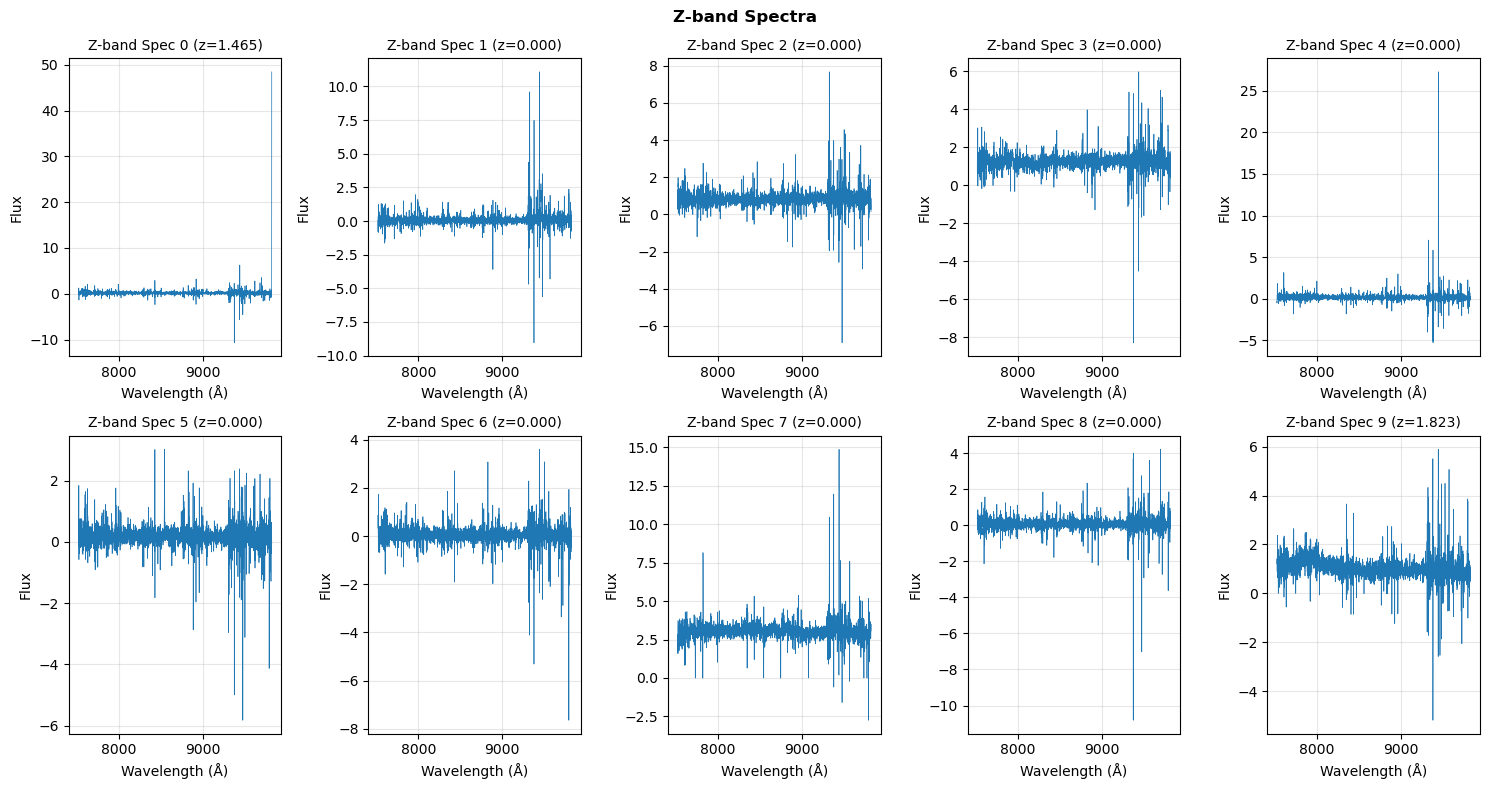

In [7]:
import matplotlib.pyplot as plt

# Plot the spectra for current band
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

for i in range(min(10, Nspec)):
    ax = axes[i]
    ax.plot(wavelength, flux[i], linewidth=0.5)
    ax.set_title(f'{current_band}-band Spec {i} (z={z_values[i]:.3f})', fontsize=10)
    ax.set_xlabel('Wavelength (Å)')
    ax.set_ylabel('Flux')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'{current_band}-band Spectra', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

In [8]:
import sys
sys.path.append('/Users/iemotoyuni/Desktop/SpenderQ/SpenderQ_Clone/SpenderQ/src')
from spenderq.spenderq import SpenderQ

In [9]:
# ========== Run SpenderQ with error handling ==========
print('Instantiating SpenderQ...')
spender = SpenderQ('qso.dr1.hiz')

print('Running SpenderQ.eval()...')
try:
    s, recon = spender.eval(spec, w, z)
except IndexError as e:
    print(f'IndexError in Lyα absorption: {e}')
    print('Trying encode/decode without Lyα masking...')
    # Just run the first model's encode/decode without iterative refinement
    with torch.no_grad():
        spender.models[0][0].eval()
        s = spender.models[0][0].encode(spec)
        recon = np.array(spender.models[0][0].decode(s))

print(f'Output shapes:')
print(f'  s (latent): {s.shape}')
print(f'  recon: {recon.shape}')
print('Done!')

Instantiating SpenderQ...
Running SpenderQ.eval()...
IndexError in Lyα absorption: boolean index did not match indexed array along dimension 0; dimension is 2881 but corresponding boolean dimension is 7781
Trying encode/decode without Lyα masking...
Output shapes:
  s (latent): torch.Size([10, 10])
  recon: (10, 9780)
Done!


Current band (Z):
  Original wavelength shape: (2881,), Recon wavelength shape: (9780,)
  Original flux shape: (10, 2881), Recon shape: (10, 9780)


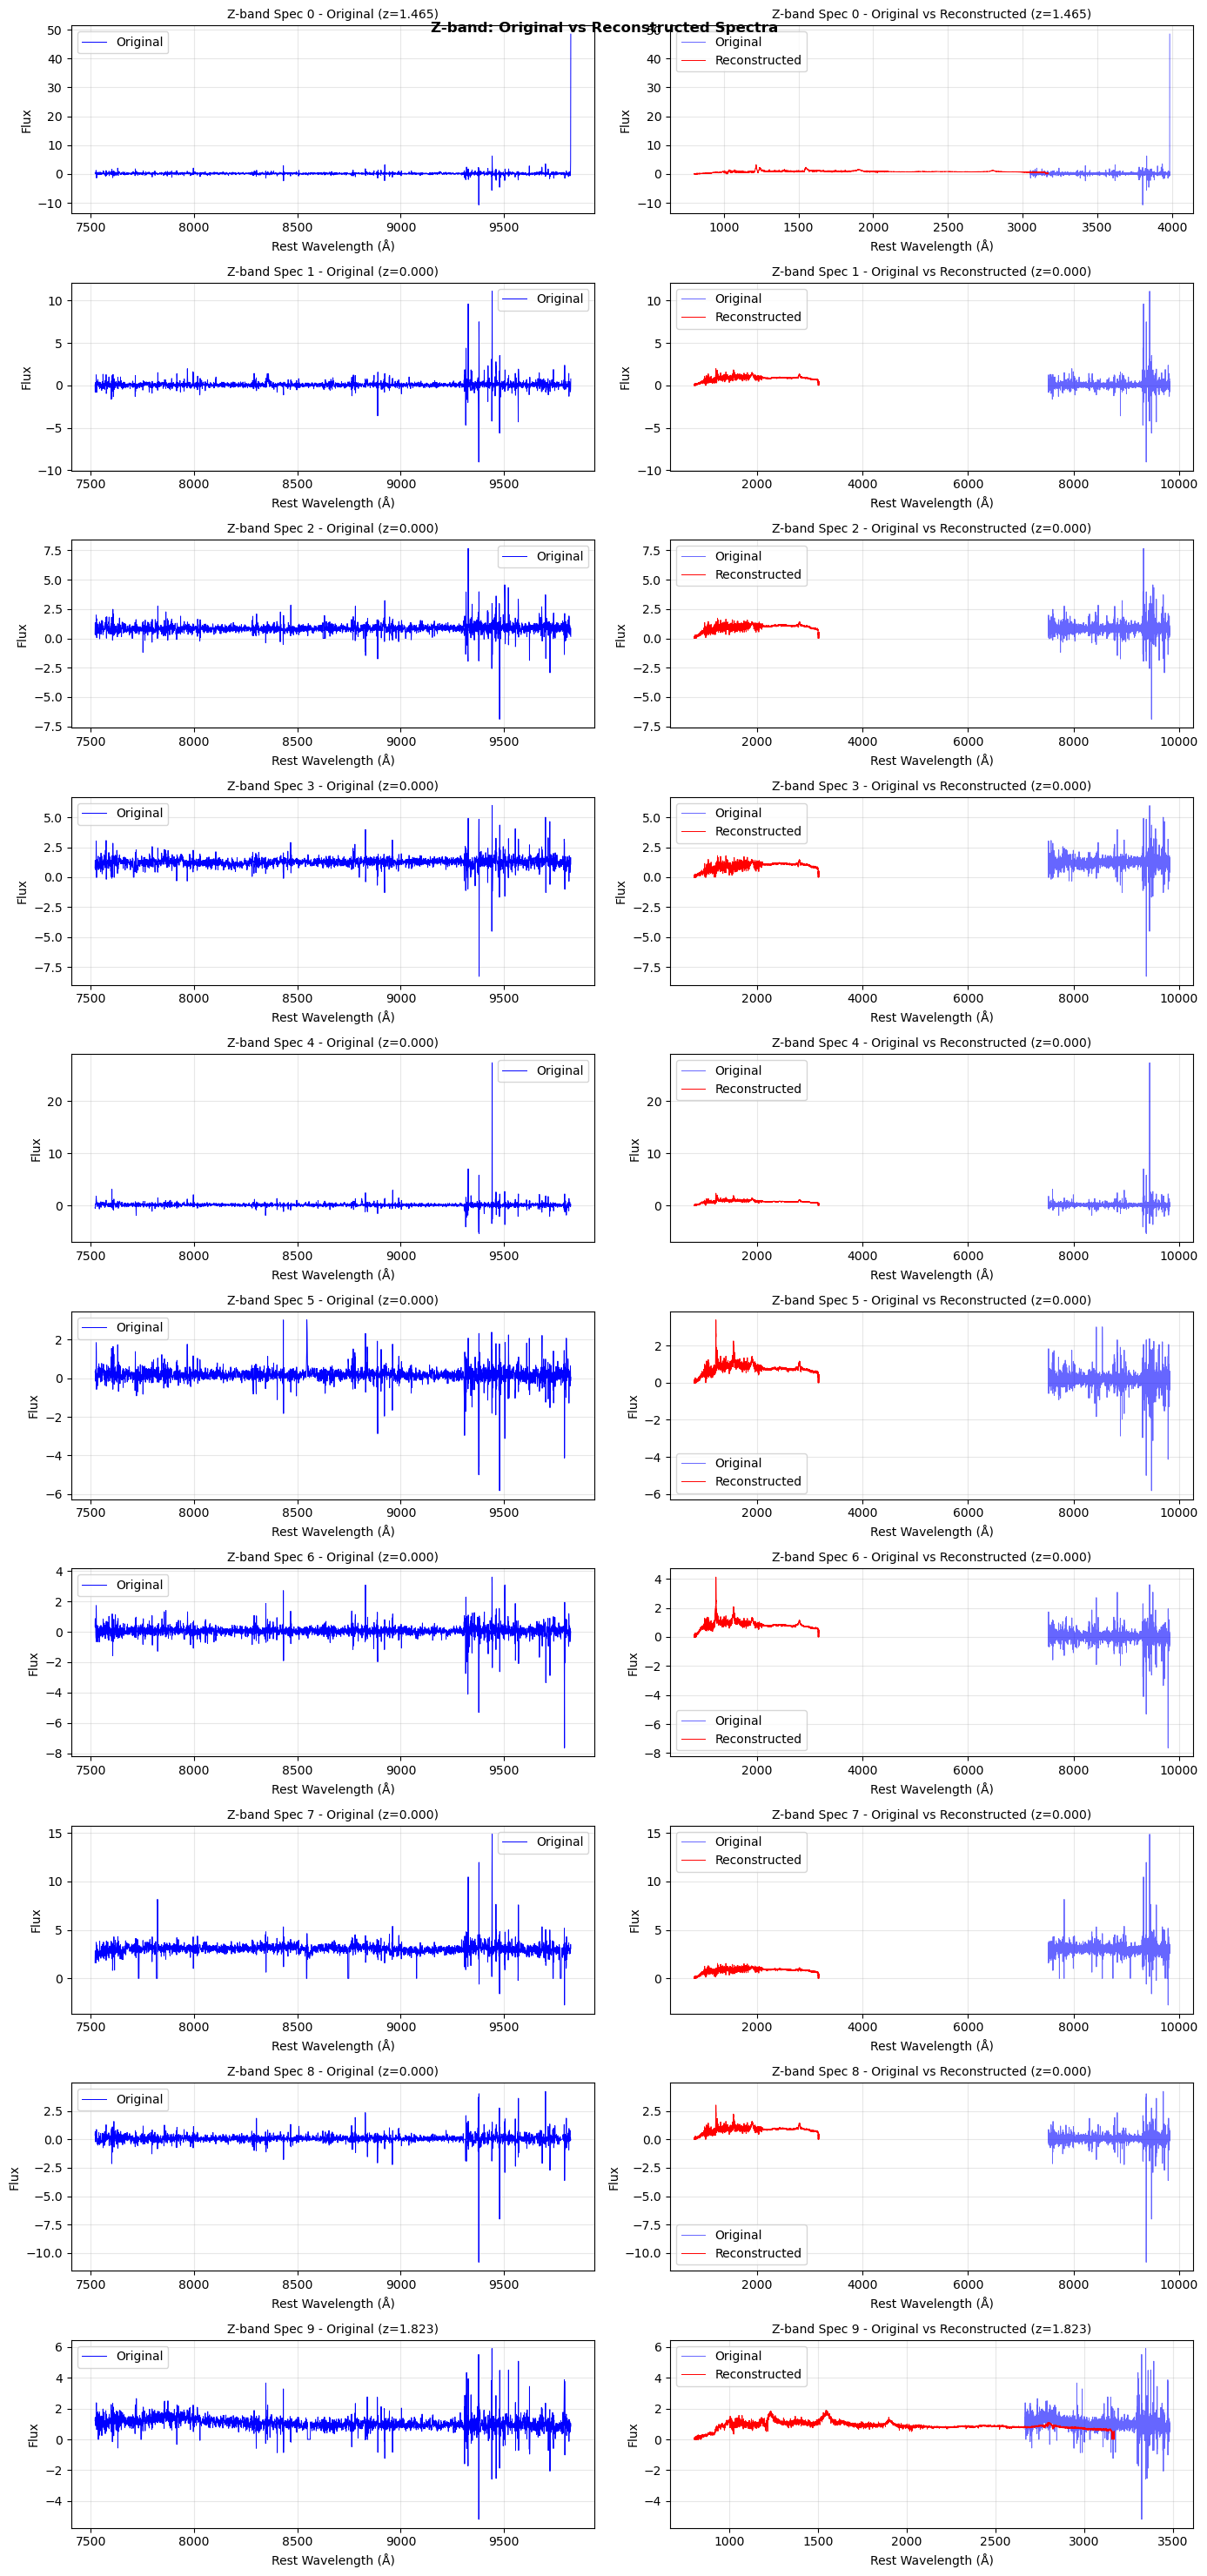

In [10]:
# Get reconstruction wavelength
wave_recon = spender.wave_recon()
print(f'Current band ({current_band}):')
print(f'  Original wavelength shape: {wavelength.shape}, Recon wavelength shape: {wave_recon.shape}')
print(f'  Original flux shape: {flux.shape}, Recon shape: {recon.shape}')

# Plot original vs reconstructed spectra
fig, axes = plt.subplots(Nspec, 2, figsize=(14, 3*Nspec))
if Nspec == 1:
    axes = axes.reshape(1, -1)

for i in range(Nspec):
    
    # Left: Original spectrum in rest frame
    axes[i, 0].plot(wavelength, flux[i], 'b-', linewidth=0.7, label='Original')
    axes[i, 0].set_title(f'{current_band}-band Spec {i} - Original (z={z_values[i]:.3f})', fontsize=10)
    axes[i, 0].set_xlabel('Rest Wavelength (Å)')
    axes[i, 0].set_ylabel('Flux')
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].legend()
    
    # Right: Original and reconstructed overlapped (both in rest frame)
    wave_rest = wavelength / (1.0 + z_values[i])
    axes[i, 1].plot(wave_rest, flux[i], 'b-', linewidth=0.7, label='Original', alpha=0.6)
    axes[i, 1].plot(wave_recon, recon[i], 'r-', linewidth=0.7, label='Reconstructed')
    axes[i, 1].set_title(f'{current_band}-band Spec {i} - Original vs Reconstructed (z={z_values[i]:.3f})', fontsize=10)
    axes[i, 1].set_xlabel('Rest Wavelength (Å)')
    axes[i, 1].set_ylabel('Flux')
    axes[i, 1].grid(True, alpha=0.3)
    axes[i, 1].legend()
    
    
plt.suptitle(f'{current_band}-band: Original vs Reconstructed Spectra', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

## coadd-*-6-thru20210417 
### first targetid [39628488923152527] in QSO_cat_iron_cumulative_v0.fits


In [11]:
import os
from pathlib import Path

target_id = 39627859723032583

# Get the tiles where this TARGETID appears
target_tiles = result['TILEID'].values
print(f"TARGETID {target_id} appears in tiles according to catalog: {target_tiles}")
print(f"\nSearching locally in tile 6 only...")

found = False
spectrum_data = None

# Only search in tile 6 (the only one available locally)
tile_6_path = "/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/cumulative/6"

# Look through all subdirectories in tile 6
for root, dirs, files in os.walk(tile_6_path):
    for filename in files:
        if filename.endswith('.fits'):
            filepath = os.path.join(root, filename)
            
            # Try to open and search for TARGETID
            try:
                with fits.open(filepath) as hdul:
                    if 'FIBERMAP' in hdul:
                        fibermap = hdul['FIBERMAP'].data
                        targetids = fibermap['TARGETID']
                        
                        # Check if our target ID is in this file
                        idx = np.where(targetids == target_id)[0]
                        if len(idx) > 0:
                            print(f"✓ Found TARGETID {target_id} in {filename} at fiber index {idx[0]}")
                            
                            # Load spectrum data
                            spectrum_data = {
                                'file': filepath,
                                'fiber_idx': idx[0],
                                'tile_id': 6,
                                'fibermap': fibermap[idx[0]],
                                'bands': {}
                            }
                            
                            # Load all available bands
                            for band in ['B', 'R', 'Z']:
                                if f'{band}_FLUX' in hdul:
                                    spectrum_data['bands'][band] = {
                                        'wavelength': np.array(hdul[f'{band}_WAVELENGTH'].data, dtype=np.float32),
                                        'flux': np.array(hdul[f'{band}_FLUX'].data[idx[0]], dtype=np.float32),
                                        'ivar': np.array(hdul[f'{band}_IVAR'].data[idx[0]], dtype=np.float32)
                                    }
                            
                            found = True
                            break
            except Exception as e:
                print(f"  Error reading {filename}: {e}")
    
    if found:
        break

if found:
    print(f"\n✓✓✓ Spectrum found! ✓✓✓")
    print(f"Tile: {spectrum_data['tile_id']}")
    print(f"File: {spectrum_data['file']}")
    print(f"Fiber index: {spectrum_data['fiber_idx']}")
    print(f"Available bands: {list(spectrum_data['bands'].keys())}")
    print(f"Redshift (from catalog): {result['Z'].values[0]}")
else:
    print(f"\n✗ TARGETID {target_id} not found in tile 6 files")

TARGETID 39627859723032583 appears in tiles according to catalog: [23644]

Searching locally in tile 6 only...
✓ Found TARGETID 39627859723032583 in coadd-5-6-thru20210417.fits at fiber index 143

✓✓✓ Spectrum found! ✓✓✓
Tile: 6
File: /Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/cumulative/6/coadd-5-6-thru20210417.fits
Fiber index: 143
Available bands: ['B', 'R', 'Z']
Redshift (from catalog): 0.48725425942143985


In [12]:
#==== just checking in if R flux is actually 0 ===

# Display and plot the loaded R-band array
if 'r_flux' in globals():
    print('r_flux shape:', r_flux.shape)
    print('r_flux dtype:', r_flux.dtype)
    print('r_flux stats: min=%g, max=%g, median=%g' % (np.nanmin(r_flux), np.nanmax(r_flux), np.nanmedian(r_flux)))
    # print first 200 values
    nshow = min(200, r_flux.size)
    print('\nFirst %d R-band pixel values:' % nshow)
    print(r_flux[:nshow])

    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 3))
    plt.plot(r_flux, '-', color='tab:purple', linewidth=0.8)
    plt.title(f'R-band flux (fiber index {spectrum_data["fiber_idx"]})')
    plt.xlabel('Pixel index')
    plt.ylabel('Flux')
    plt.grid(alpha=0.3)
    plt.show()
else:
    print('r_flux is not defined. Run the R-band loader cell first.')

r_flux is not defined. Run the R-band loader cell first.


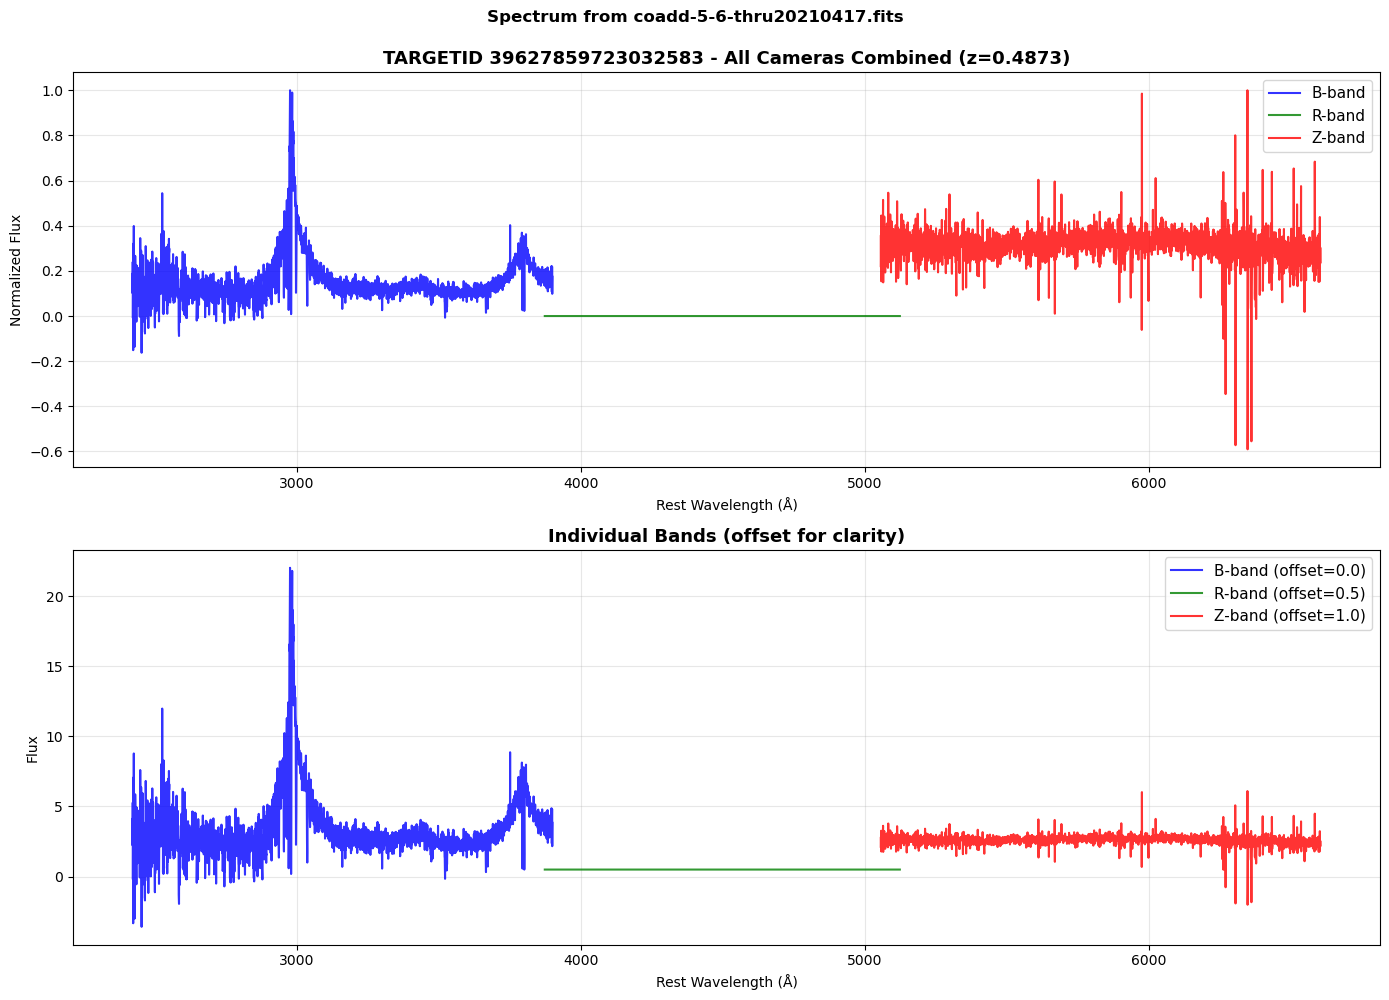


=== Combined Spectrum Details ===
Fiber index: 143
Redshift: 0.487254
Bands available: ['B', 'R', 'Z']
  B: 2751 pixels | Observed: 3600.0-5800.0 Å | Rest: 2420.6-3899.8 Å
  R: 2326 pixels | Observed: 5760.0-7620.0 Å | Rest: 3872.9-5123.5 Å
  Z: 2881 pixels | Observed: 7520.0-9824.0 Å | Rest: 5056.3-6605.5 Å


In [13]:
if found:
    # Get redshift from catalog
    z_qso = result['Z'].values[0]
    
    # Create figure with combined and individual views
    bands_available = list(spectrum_data['bands'].keys())
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color map for bands
    colors = {'B': 'blue', 'R': 'green', 'Z': 'red'}
    
    # Top plot: All bands combined
    for band in bands_available:
        band_data = spectrum_data['bands'][band]
        wavelength_obs = band_data['wavelength']
        flux_obs = band_data['flux']
        
        # Convert to rest frame
        wavelength_rest = wavelength_obs / (1.0 + z_qso)
        
        # Normalize flux for visualization (optional, remove if you want raw flux)
        flux_normalized = flux_obs / np.max(np.abs(flux_obs)) if np.max(np.abs(flux_obs)) > 0 else flux_obs
        
        axes[0].plot(wavelength_rest, flux_normalized, color=colors.get(band, 'black'), 
                    linewidth=1.5, label=f'{band}-band', alpha=0.8)
    
    axes[0].set_title(f'TARGETID {target_id} - All Cameras Combined (z={z_qso:.4f})', 
                     fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Rest Wavelength (Å)')
    axes[0].set_ylabel('Normalized Flux')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right', fontsize=11)
    
    # Bottom plot: Individual bands stacked
    for idx, band in enumerate(bands_available):
        band_data = spectrum_data['bands'][band]
        wavelength_obs = band_data['wavelength']
        flux_obs = band_data['flux']
        
        # Convert to rest frame
        wavelength_rest = wavelength_obs / (1.0 + z_qso)
        
        # Offset for stacking visualization
        offset = idx * 0.5
        axes[1].plot(wavelength_rest, flux_obs + offset, color=colors.get(band, 'black'), 
                    linewidth=1.5, label=f'{band}-band (offset={offset})', alpha=0.8)
    
    axes[1].set_title(f'Individual Bands (offset for clarity)', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Rest Wavelength (Å)')
    axes[1].set_ylabel('Flux')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right', fontsize=11)
    
    plt.suptitle(f'Spectrum from {spectrum_data["file"].split("/")[-1]}', 
                fontsize=12, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== Combined Spectrum Details ===")
    print(f"Fiber index: {spectrum_data['fiber_idx']}")
    print(f"Redshift: {z_qso:.6f}")
    print(f"Bands available: {bands_available}")
    for band in bands_available:
        nwave = len(spectrum_data['bands'][band]['flux'])
        wave_obs = spectrum_data['bands'][band]['wavelength']
        wave_rest = wave_obs / (1.0 + z_qso)
        print(f"  {band}: {nwave} pixels | Observed: {wave_obs[0]:.1f}-{wave_obs[-1]:.1f} Å | Rest: {wave_rest[0]:.1f}-{wave_rest[-1]:.1f} Å")
else:
    print("No spectrum found. Run the search cell first.")

In [14]:
# ========== Run SpenderQ on found spectrum (B and Z cameras only) ==========
if found:
    z_qso = result['Z'].values[0]
    
    # Use only B and Z cameras (skip R)
    selected_bands = ['B', 'Z']
    
    print(f"Processing TARGETID {target_id} with {selected_bands} cameras only")
    print(f"Redshift: {z_qso:.6f}\n")
    
    spender_results = {}
    
    for band in selected_bands:
        print(f"\n{'='*60}")
        print(f"Processing {band}-band")
        print('='*60)
        
        if band not in spectrum_data['bands']:
            print(f"  ✗ {band}-band not available")
            continue
        
        band_data = spectrum_data['bands'][band]
        flux_band = band_data['flux']
        ivar_band = band_data['ivar']
        
        print(f"  Flux shape: {flux_band.shape}")
        print(f"  iVar shape: {ivar_band.shape}")
        
        # Reshape to (1, Nwave) for single spectrum
        flux_single = flux_band.reshape(1, -1)
        ivar_single = ivar_band.reshape(1, -1)
        z_single = np.array([z_qso], dtype=np.float32)
        
        # Convert to torch tensors
        spec_tensor = torch.tensor(flux_single, dtype=torch.float32)
        w_tensor = torch.tensor(ivar_single, dtype=torch.float32)
        z_tensor = torch.tensor(z_single, dtype=torch.float32)
        
        print(f"  Running SpenderQ.eval()...")
        try:
            s, recon = spender.eval(spec_tensor, w_tensor, z_tensor)
        except IndexError as e:
            print(f"  IndexError in Lyα absorption: {e}")
            print(f"  Trying encode/decode without Lyα masking...")
            with torch.no_grad():
                spender.models[0][0].eval()
                s = spender.models[0][0].encode(spec_tensor)
                recon = np.array(spender.models[0][0].decode(s))
        
        spender_results[band] = {
            'flux': flux_band,
            'ivar': ivar_band,
            'wavelength': band_data['wavelength'],
            'latent': s,
            'recon': recon
        }
        
        print(f"  ✓ Latent shape: {s.shape}")
        print(f"  ✓ Reconstruction shape: {recon.shape}")
    
    print(f"\n{'='*60}")
    print(f"✓ SpenderQ processing complete!")
    print(f"{'='*60}")
else:
    print("No spectrum found. Run the search cell first.")

Processing TARGETID 39627859723032583 with ['B', 'Z'] cameras only
Redshift: 0.487254


Processing B-band
  Flux shape: (2751,)
  iVar shape: (2751,)
  Running SpenderQ.eval()...
  IndexError in Lyα absorption: boolean index did not match indexed array along dimension 0; dimension is 2751 but corresponding boolean dimension is 7781
  Trying encode/decode without Lyα masking...
  ✓ Latent shape: torch.Size([1, 10])
  ✓ Reconstruction shape: (1, 9780)

Processing Z-band
  Flux shape: (2881,)
  iVar shape: (2881,)
  Running SpenderQ.eval()...
  IndexError in Lyα absorption: boolean index did not match indexed array along dimension 0; dimension is 2881 but corresponding boolean dimension is 7781
  Trying encode/decode without Lyα masking...
  ✓ Latent shape: torch.Size([1, 10])
  ✓ Reconstruction shape: (1, 9780)

✓ SpenderQ processing complete!


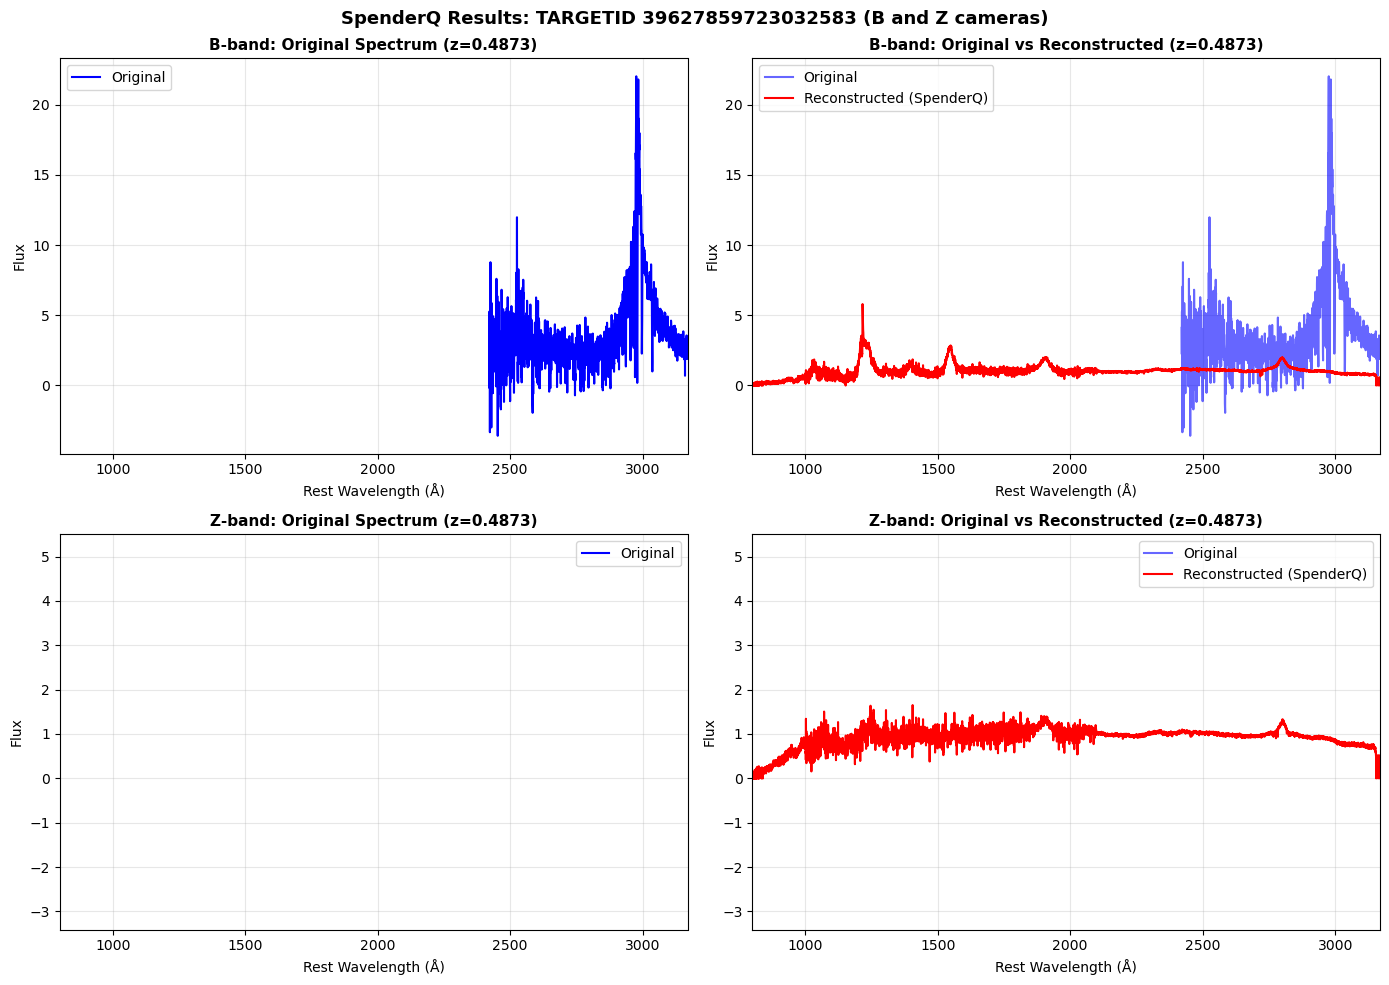


=== SpenderQ Latent Representations ===
B-band latent shape: torch.Size([1, 10])
  Latent vector (first 10 dims): tensor([ 2.0638,  1.3236, -1.3181, -2.1508,  1.3108,  0.4560,  2.1544, -1.7015,
         1.2429, -3.1218])
Z-band latent shape: torch.Size([1, 10])
  Latent vector (first 10 dims): tensor([ 2.0389,  1.5672,  0.6132, -1.2399,  0.6450, -0.5387, -0.4984, -1.8508,
         0.0833, -3.4209])


In [15]:
if found and spender_results:
    z_qso = result['Z'].values[0]
    wave_recon = spender.wave_recon()
    
    # Create figure with original vs reconstructed for each band
    n_bands = len(spender_results)
    fig, axes = plt.subplots(n_bands, 2, figsize=(14, 5*n_bands))
    if n_bands == 1:
        axes = axes.reshape(1, -1)
    
    for ax_idx, band in enumerate(sorted(spender_results.keys())):
        result_band = spender_results[band]
        flux = result_band['flux']
        wavelength = result_band['wavelength']
        recon = result_band['recon'][0]  # First (only) spectrum
        
        # Convert to rest frame
        wavelength_rest = wavelength / (1.0 + z_qso)
        
        # Left plot: Original spectrum
        axes[ax_idx, 0].plot(wavelength_rest, flux, 'b-', linewidth=1.5, label='Original')
        axes[ax_idx, 0].set_title(f'{band}-band: Original Spectrum (z={z_qso:.4f})', fontsize=11, fontweight='bold')
        axes[ax_idx, 0].set_xlabel('Rest Wavelength (Å)')
        axes[ax_idx, 0].set_ylabel('Flux')
        axes[ax_idx, 0].grid(True, alpha=0.3)
        axes[ax_idx, 0].legend(fontsize=10)
        
        # Right plot: Original + Reconstructed overlapped
        axes[ax_idx, 1].plot(wavelength_rest, flux, 'b-', linewidth=1.5, label='Original', alpha=0.6)
        axes[ax_idx, 1].plot(wave_recon, recon, 'r-', linewidth=1.5, label='Reconstructed (SpenderQ)')
        axes[ax_idx, 1].set_title(f'{band}-band: Original vs Reconstructed (z={z_qso:.4f})', fontsize=11, fontweight='bold')
        axes[ax_idx, 1].set_xlabel('Rest Wavelength (Å)')
        axes[ax_idx, 1].set_ylabel('Flux')
        axes[ax_idx, 1].grid(True, alpha=0.3)
        axes[ax_idx, 1].legend(fontsize=10)
        
        # Unify wavelength range
        wave_min = wave_recon.min()
        wave_max = wave_recon.max()
        axes[ax_idx, 0].set_xlim(wave_min, wave_max)
        axes[ax_idx, 1].set_xlim(wave_min, wave_max)
    
    plt.suptitle(f'SpenderQ Results: TARGETID {target_id} (B and Z cameras)', 
                fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== SpenderQ Latent Representations ===")
    for band in sorted(spender_results.keys()):
        latent = spender_results[band]['latent']
        print(f"{band}-band latent shape: {latent.shape}")
        print(f"  Latent vector (first 10 dims): {latent[0][:10]}")
else:
    print("No SpenderQ results found. Run the SpenderQ processing cell first.")

## coadd-5-6-20210417.fits
### the exact same id but from pernight instead of cumulative

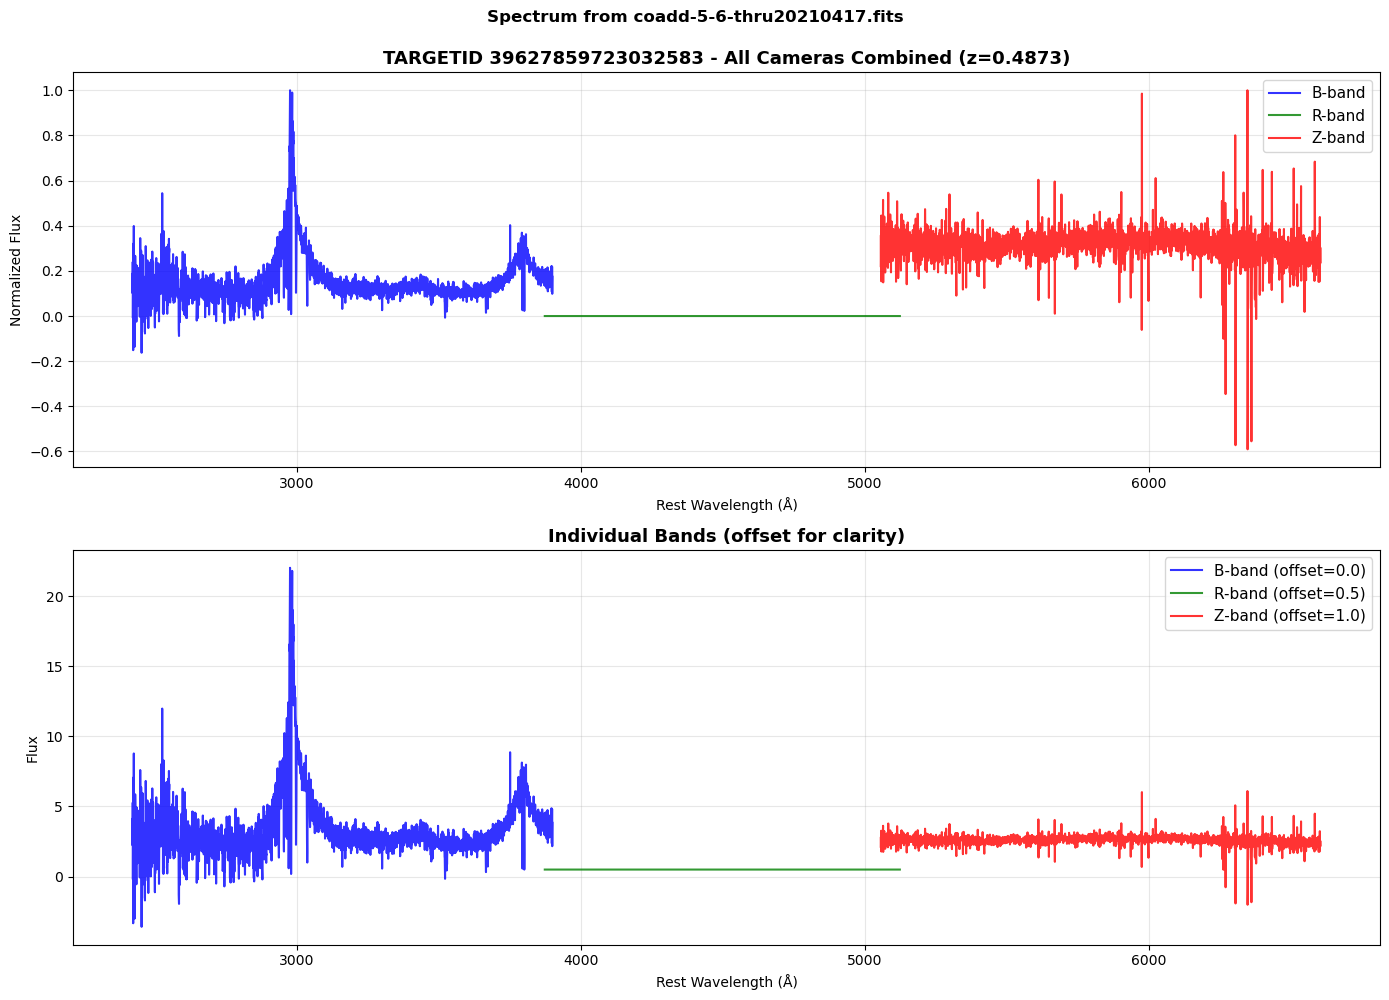


=== Combined Spectrum Details ===
Fiber index: 143
Redshift: 0.487254
Bands available: ['B', 'R', 'Z']
  B: 2751 pixels | Observed: 3600.0-5800.0 Å | Rest: 2420.6-3899.8 Å
  R: 2326 pixels | Observed: 5760.0-7620.0 Å | Rest: 3872.9-5123.5 Å
  Z: 2881 pixels | Observed: 7520.0-9824.0 Å | Rest: 5056.3-6605.5 Å


In [16]:
pernight_path= '/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/pernight/6/20210417/coadd-5-6-20210417.fits'
target_id = 39627859723032583

if found:
    # Get redshift from catalog
    z_qso = result['Z'].values[0]
    
    # Create figure with combined and individual views
    bands_available = list(spectrum_data['bands'].keys())
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Color map for bands
    colors = {'B': 'blue', 'R': 'green', 'Z': 'red'}
    
    # Top plot: All bands combined
    for band in bands_available:
        band_data = spectrum_data['bands'][band]
        wavelength_obs = band_data['wavelength']
        flux_obs = band_data['flux']
        
        # Convert to rest frame
        wavelength_rest = wavelength_obs / (1.0 + z_qso)
        
        # Normalize flux for visualization (optional, remove if you want raw flux)
        flux_normalized = flux_obs / np.max(np.abs(flux_obs)) if np.max(np.abs(flux_obs)) > 0 else flux_obs
        
        axes[0].plot(wavelength_rest, flux_normalized, color=colors.get(band, 'black'), 
                    linewidth=1.5, label=f'{band}-band', alpha=0.8)
    
    axes[0].set_title(f'TARGETID {target_id} - All Cameras Combined (z={z_qso:.4f})', 
                     fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Rest Wavelength (Å)')
    axes[0].set_ylabel('Normalized Flux')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend(loc='upper right', fontsize=11)
    
    # Bottom plot: Individual bands stacked
    for idx, band in enumerate(bands_available):
        band_data = spectrum_data['bands'][band]
        wavelength_obs = band_data['wavelength']
        flux_obs = band_data['flux']
        
        # Convert to rest frame
        wavelength_rest = wavelength_obs / (1.0 + z_qso)
        
        # Offset for stacking visualization
        offset = idx * 0.5
        axes[1].plot(wavelength_rest, flux_obs + offset, color=colors.get(band, 'black'), 
                    linewidth=1.5, label=f'{band}-band (offset={offset})', alpha=0.8)
    
    axes[1].set_title(f'Individual Bands (offset for clarity)', fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Rest Wavelength (Å)')
    axes[1].set_ylabel('Flux')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(loc='upper right', fontsize=11)
    
    plt.suptitle(f'Spectrum from {spectrum_data["file"].split("/")[-1]}', 
                fontsize=12, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n=== Combined Spectrum Details ===")
    print(f"Fiber index: {spectrum_data['fiber_idx']}")
    print(f"Redshift: {z_qso:.6f}")
    print(f"Bands available: {bands_available}")
    for band in bands_available:
        nwave = len(spectrum_data['bands'][band]['flux'])
        wave_obs = spectrum_data['bands'][band]['wavelength']
        wave_rest = wave_obs / (1.0 + z_qso)
        print(f"  {band}: {nwave} pixels | Observed: {wave_obs[0]:.1f}-{wave_obs[-1]:.1f} Å | Rest: {wave_rest[0]:.1f}-{wave_rest[-1]:.1f} Å")
else:
    print("No spectrum found. Run the search cell first.")

### laod pernight but cumulative and pernight is the same if i just use one spectrum of the same targeid (obviously)

Checking pernight file: /Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/pernight/6/20210417/coadd-5-6-20210417.fits
Found TARGETID 39627859723032583 in pernight file at fiber index 143


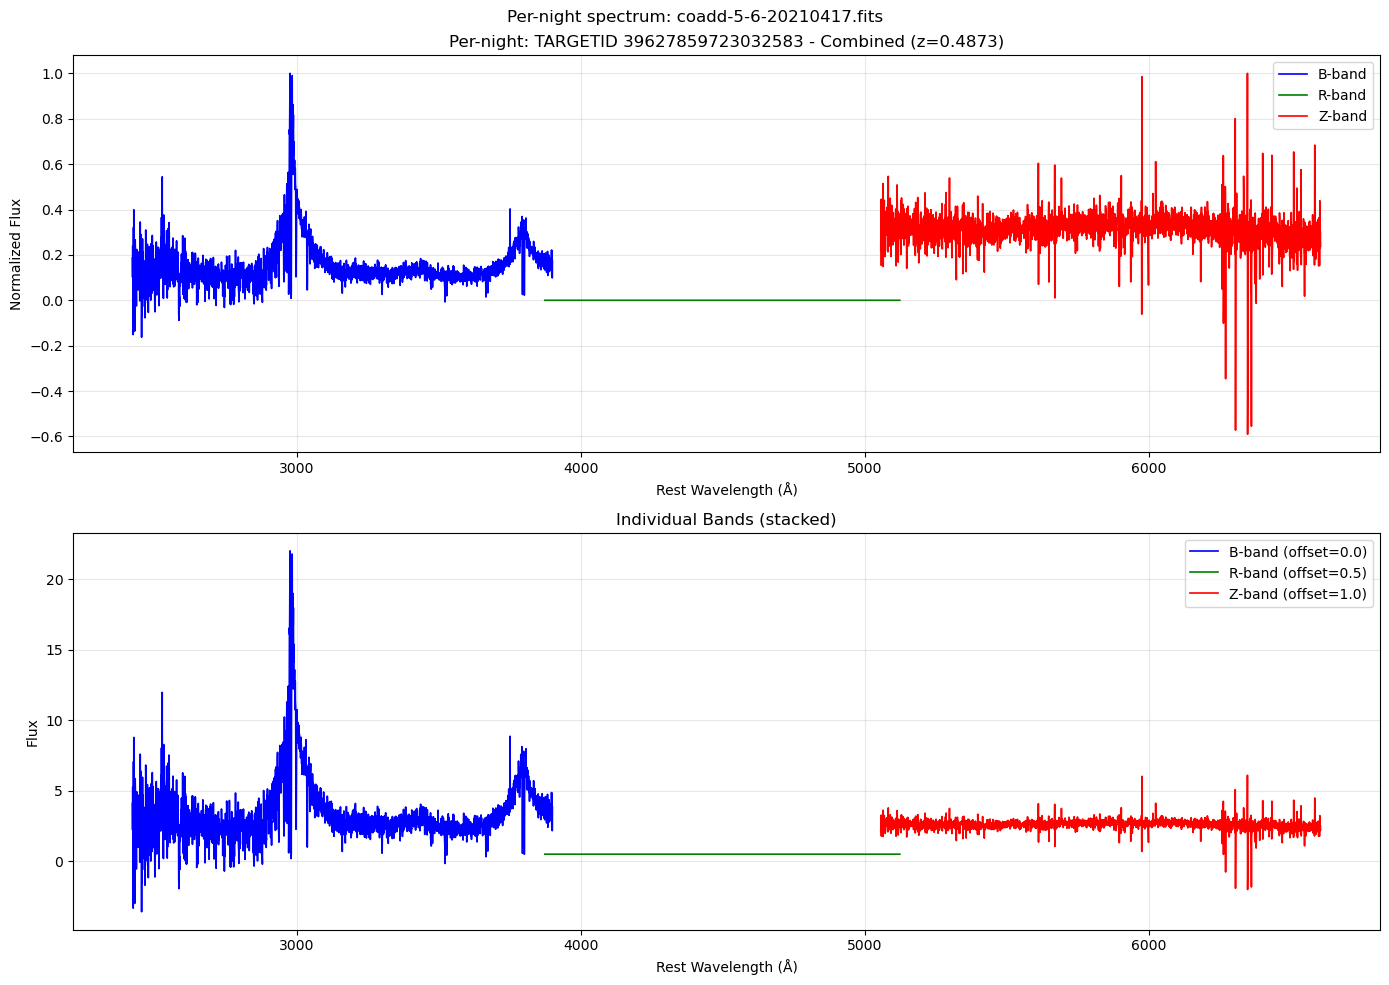

In [17]:
# Load pernight coadd and plot this TARGETID if present
pernight_path = '/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/pernight/6/20210417/coadd-5-6-20210417.fits'
target_id = 39627859723032583

print(f'Checking pernight file: {pernight_path}')
try:
    with fits.open(pernight_path) as hdul:
        if 'FIBERMAP' not in hdul:
            print('No FIBERMAP in pernight file')
        else:
            pfibermap = hdul['FIBERMAP'].data
            p_targetids = pfibermap['TARGETID']
            p_idx = np.where(p_targetids == target_id)[0]
            if len(p_idx) == 0:
                print(f'TARGETID {target_id} not found in pernight file')
            else:
                p_idx = p_idx[0]
                print(f'Found TARGETID {target_id} in pernight file at fiber index {p_idx}')
                pernight_spectrum = {'file': pernight_path, 'fiber_idx': p_idx, 'bands': {}}
                for band in ['B','R','Z']:
                    wkey = f'{band}_WAVELENGTH'
                    fkey = f'{band}_FLUX'
                    ivkey = f'{band}_IVAR'
                    if wkey in hdul and fkey in hdul and ivkey in hdul:
                        pernight_spectrum['bands'][band] = {
                            'wavelength': np.array(hdul[wkey].data, dtype=np.float32),
                            'flux': np.array(hdul[fkey].data[p_idx], dtype=np.float32),
                            'ivar': np.array(hdul[ivkey].data[p_idx], dtype=np.float32)
                        }
                # plotting (use redshift from catalog if available)
                if 'Z' in result.columns:
                    z_qso = result['Z'].values[0]
                else:
                    z_qso = 0.0
                bands_available = list(pernight_spectrum['bands'].keys())
                if len(bands_available) == 0:
                    print('No bands available in pernight file for this fiber')
                else:
                    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
                    colors = {'B':'blue','R':'green','Z':'red'}
                    for band in bands_available:
                        band_data = pernight_spectrum['bands'][band]
                        wavelength_obs = band_data['wavelength']
                        flux_obs = band_data['flux']
                        wavelength_rest = wavelength_obs / (1.0 + z_qso) if z_qso>0 else wavelength_obs
                        flux_normalized = flux_obs / np.max(np.abs(flux_obs)) if np.max(np.abs(flux_obs))>0 else flux_obs
                        axes[0].plot(wavelength_rest, flux_normalized, color=colors.get(band,'black'), linewidth=1.2, label=f'{band}-band')
                    axes[0].set_title(f'Per-night: TARGETID {target_id} - Combined (z={z_qso:.4f})')
                    axes[0].set_xlabel('Rest Wavelength (Å)')
                    axes[0].set_ylabel('Normalized Flux')
                    axes[0].grid(True, alpha=0.3)
                    axes[0].legend()

                    for idx, band in enumerate(bands_available):
                        band_data = pernight_spectrum['bands'][band]
                        wavelength_obs = band_data['wavelength']
                        flux_obs = band_data['flux']
                        wavelength_rest = wavelength_obs / (1.0 + z_qso) if z_qso>0 else wavelength_obs
                        offset = idx * 0.5
                        axes[1].plot(wavelength_rest, flux_obs + offset, color=colors.get(band,'black'), linewidth=1.2, label=f'{band}-band (offset={offset})')
                    axes[1].set_title('Individual Bands (stacked)')
                    axes[1].set_xlabel('Rest Wavelength (Å)')
                    axes[1].set_ylabel('Flux')
                    axes[1].grid(True, alpha=0.3)
                    axes[1].legend()
                    plt.suptitle(f'Per-night spectrum: {pernight_path.split('/')[-1]}')
                    plt.tight_layout()
                    plt.show()
except Exception as e:
    print(f'Error opening pernight file: {e}')

## preprocess from preprocess.py


In [ ]:

def prepare_spectra(tileid, ipetal, qso): #, zbin='high'): 
    ''' prepare QSO spectra in a tile 
    '''
    # read co-add. These are cumulative exposures based on TILEID
    dir_tile = os.path.join('/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/cumulative', str(tileid))
    assert len(glob.glob(dir_tile+'/*')) == 1

    #fixed night 
    # night = glob.glob(dir_tile+'/*')[0].split('/')[-1]

    night = "20201216"
    dir_coadd = os.path.join(dir_tile, night) 

    fspec = os.path.join(dir_coadd, 'coadd-%i-%i-thru%s.fits' % (ipetal, tileid, night))
    assert os.path.isfile(fspec)
   
    # read spectra file
    hdulist = fits.open(fspec)
    meta = Table.read(fspec) # meta data
    target_id = hdulist[1].data['TARGETID'] # unique target ID

    keep = np.zeros(len(meta)).astype(bool)
    z, zerr = np.zeros(len(meta)), np.zeros(len(meta))

    qso_tile = qso[(qso['TILEID'] == tileid)]
    for targetid, _z, _zerr in zip(qso_tile['TARGETID'], qso_tile['Z'], qso_tile['ZERR']): 
        keep = keep | (target_id == targetid)
        z[target_id == targetid] = _z
        zerr[target_id == targetid] = _zerr
    
    # read in data
    _wave, _flux, _ivar, _mask, _res = {}, {}, {}, {}, {}
    for h in range(2, len(hdulist)):
        if "WAVELENGTH" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _wave[band] = hdulist[h].data
        if "FLUX" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _flux[band] = hdulist[h].data
        if "IVAR" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _ivar[band] = hdulist[h].data
        if "MASK" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _mask[band] = hdulist[h].data
        if "RESOLUTION" in hdulist[h].header["EXTNAME"]:
            band = hdulist[h].header["EXTNAME"].split("_")[0].lower()
            _res[band] = hdulist[h].data
    # coadd the b, r, z arm spectra (scraped from
    # https://github.com/desihub/desispec/blob/main/py/desispec/coaddition.py#L529)
    tolerance = 0.0001  # A , tolerance
    wave = _wave["b"]
    for b in ["b", "r", "z"]:
        wave = np.append(wave, _wave[b][_wave[b] > wave[-1] + tolerance])
    nwave = wave.size
    ntarget = _flux["b"].shape[0]
    check_agreement = torch.abs(torch.from_numpy(wave) - desiQSO._wave_obs)
    if check_agreement.max() > tolerance:
        print(
            "Warning: input wavelength grids inconsistent with class variable wave_obs!"
        )
    # check alignment, caching band wavelength grid indices as we go
    windict = {}
    number_of_overlapping_cameras = np.zeros(nwave)
    for b in ["b", "r", "z"]:
        imin = np.argmin(np.abs(_wave[b][0] - wave))
        windices = np.arange(imin, imin + len(_wave[b]), dtype=int)
        dwave = _wave[b] - wave[windices]

        if np.any(np.abs(dwave) > tolerance):
            msg = "Input wavelength grids (band '{}') are not aligned. Use --lin-step or --log10-step to resample to a common grid.".format(
                b
            )
            raise ValueError(msg)
        number_of_overlapping_cameras[windices] += 1
        windict[b] = windices

    # ndiag = max of all cameras
    ndiag = 0
    for b in ["b", "r", "z"]:
        ndiag = max(ndiag, _res[b].shape[1])

    flux = np.zeros((ntarget, nwave), dtype=_flux["b"].dtype)
    ivar = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    ivar_unmasked = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)
    mask = np.zeros((ntarget, nwave), dtype=_mask["b"].dtype)
    rdata = np.zeros((ntarget, ndiag, nwave), dtype=_res["b"].dtype)

    for b in ["b", "r", "z"]:
        # indices
        windices = windict[b]

        band_ndiag = _res[b].shape[1]

        for i in range(ntarget):
            ivar_unmasked[i, windices] += np.sum(_ivar[b][i], axis=0)
            ivar[i, windices] += _ivar[b][i] * (_mask[b][i] == 0)
            flux[i, windices] += _ivar[b][i] * (_mask[b][i] == 0) * _flux[b][i]
            for r in range(band_ndiag):
                rdata[i, r + (ndiag - band_ndiag) // 2, windices] += (
                    _ivar[b][i] * _res[b][i, r]
                )

            # directly copy mask where no overlap
            jj = number_of_overlapping_cameras[windices] == 1
            mask[i, windices[jj]] = _mask[b][i][jj]

            # 'and' in overlapping regions
            jj = number_of_overlapping_cameras[windices] > 1
            mask[i, windices[jj]] = mask[i, windices[jj]] & _mask[b][i][jj]

    for i in range(ntarget):
        ok = ivar[i] > 0
        if np.sum(ok) > 0:
            flux[i][ok] /= ivar[i][ok]
        ok = ivar_unmasked[i] > 0
        if np.sum(ok) > 0:
            rdata[i][:, ok] /= ivar_unmasked[i][ok]
            
    # apply bitmask, remove small values
    mask = mask.astype(bool) | (ivar <= 1e-6)
    ivar[mask] = 0

    # explicit type conversion to float32 to get to little endian
    spec = torch.from_numpy(flux[keep].astype(np.float32))
    w = torch.from_numpy(ivar[keep].astype(np.float32))
    target_id = torch.from_numpy(target_id[keep].astype(np.int64))

    # remove regions around skylines
    w[:, desiQSO._skyline_mask] = 0
    
    z = torch.tensor(z[keep].astype(np.float32))
    zerr = torch.tensor(zerr[keep].astype(np.float32))
    
    # normalize spectra:
    norm = torch.zeros(np.sum(keep))
    for i in range(np.sum(keep)):
        # for redshift invariant encoder: select norm window in restframe
        wave_rest = desiQSO._wave_obs / (1 + z[i])
        # wavelength range with no spectral lines
        # this wavelength range is set by the CIII absorprtion wavelengths. 
        # CIII absorption is small and thus should not contribute significantly
        # to estimating the normalization
        sel = (w[i] > 0) & (wave_rest > 1600) & (wave_rest < 1800) #(wave_rest > 5300) & (wave_rest < 5850)
        
        if sel.count_nonzero() > 0:
            norm[i] = torch.median(spec[i][sel])
        # remove spectra (from training) for which no valid norm could be found
        if not torch.isfinite(norm[i]):
            norm[i] = 0
        else:
            spec[i] /= norm[i]
        w[i] *= norm[i]**2

    # selects finite fluxes
    keep = (spec.isfinite().sum(axis=-1) == nwave).numpy()
    print("keep: %d / %d"%(keep.sum(),len(keep)))
    return spec[keep], w[keep], z[keep], target_id[keep],  norm[keep], zerr[keep]

In [82]:
qso_highz = qsos[(qsos['Z'] > 2.1) & (qsos['Z'] < 3.5)]


In [83]:
len(qso_highz)


834951

In [87]:
spec, w, z, target_id, norm, zerr = prepare_spectra(80615, 0, qso_highz)


keep: 15 / 15


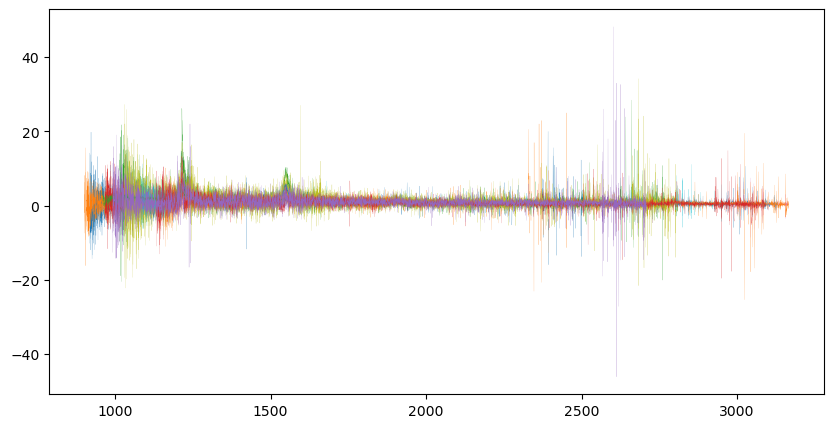

In [88]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
for _spec, _z in zip(spec, z):
    sub.plot(desiQSO._wave_obs / (1 + _z), _spec, lw=0.1)

#sub.set_ylim(-10, 10)

In [ ]:
#within ID=80615, i want to find quasar id then just save them or extract them from the batch file and then run spenderq

In [95]:
# ...existing code...
tileid = 80615
z_min, z_max = 2.1, 3.5  # set your Z range

# 1) filter tile_df_80615 by Z (expect 87)
qso_tile_z = qsos[(qsos['TILEID'] == tileid) & (qsos['Z'] >= z_min) & (qsos['Z'] <= z_max)]
target_count = len(qso_tile_z)
print(f"Targets in tile+Z range: {target_count}")

# 2) preprocess only those targets
petals = np.unique(qso_tile_z['PETAL_LOC'])
spec_all, w_all, z_all, tid_all, norm_all, zerr_all = None, None, None, None, None, None

for ipetal in petals:
    spec, w, z, target_id, norm, zerr = prepare_spectra(tileid, ipetal, qso_tile_z)

    if spec_all is None:
        spec_all, w_all, z_all, tid_all, norm_all, zerr_all = spec, w, z, target_id, norm, zerr
    else:
        spec_all = torch.concatenate([spec_all, spec], axis=0)
        w_all = torch.concatenate([w_all, w], axis=0)
        z_all = torch.concatenate([z_all, z], axis=0)
        tid_all = torch.concatenate([tid_all, target_id], axis=0)
        norm_all = torch.concatenate([norm_all, norm], axis=0)
        zerr_all = torch.concatenate([zerr_all, zerr], axis=0)

print(f"Found spectra: {spec_all.shape[0]} / {target_count}")

# 3) save batch
batch = [spec_all, w_all, z_all, tid_all, norm_all, zerr_all]
desiQSO.save_batch(
    '/Users/iemotoyuni/Desktop/SpenderQ/quassiQ/spender_qso/train/dr1',
    batch,
    tag='.dr1.qsohiz',
    counter=0
)
# ...existing code...

Targets in tile+Z range: 87
keep: 15 / 15
keep: 2 / 2
keep: 5 / 5
keep: 7 / 7
keep: 10 / 10
keep: 11 / 11
keep: 6 / 6
keep: 10 / 10
keep: 11 / 11
keep: 10 / 10
Found spectra: 87 / 87


'/Users/iemotoyuni/Desktop/SpenderQ/quassiQ/spender_qso/train/dr1/DESI.dr1.qsohiz_0.pkl'

keep: 15 / 15


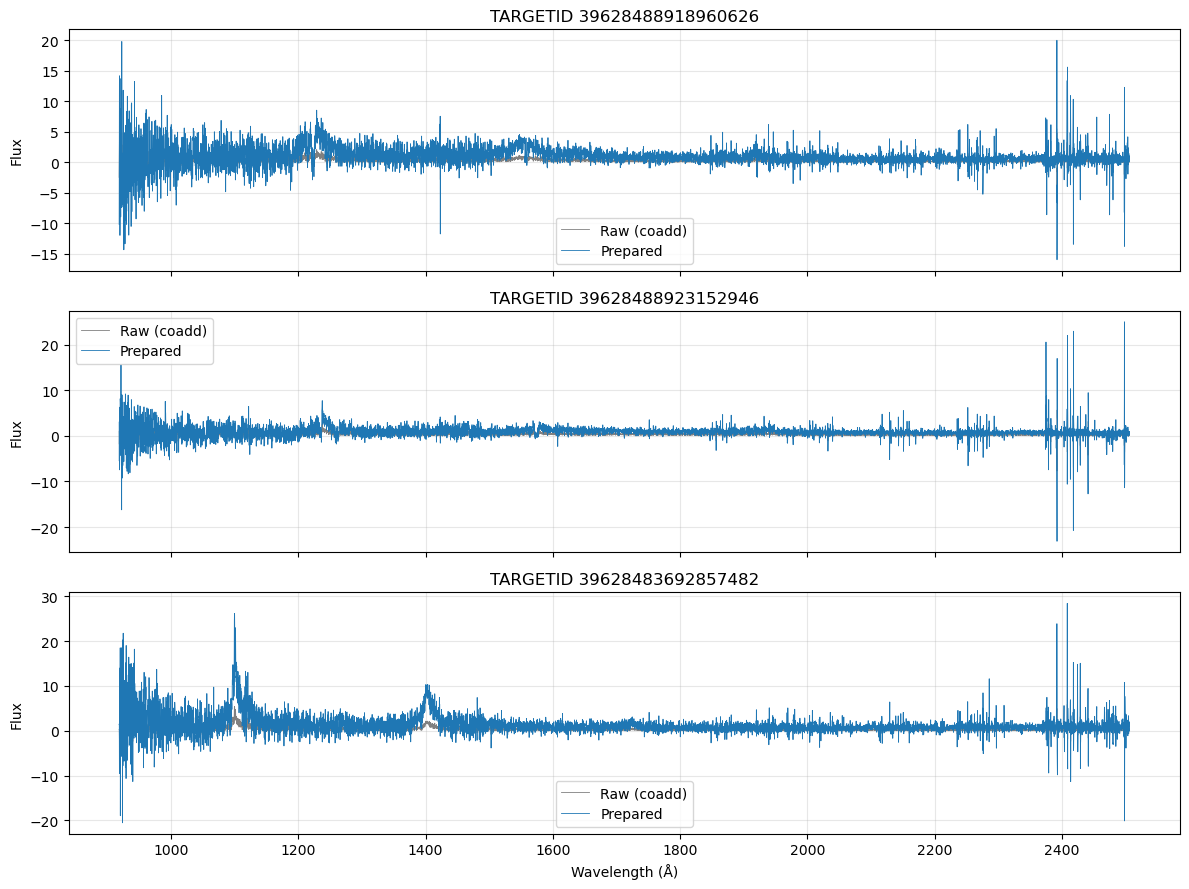

In [106]:
def _load_raw_tile_spectra(tileid, ipetal, target_ids):
    dir_tile = os.path.join('/Users/iemotoyuni/Desktop/SpenderQ/tiny_dr1/spectro/redux/iron/tiles/cumulative', str(tileid))
    night = glob.glob(dir_tile+'/*')[0].split('/')[-1]
    night = "20201216"
    fspec = os.path.join(dir_tile, night, f'coadd-{ipetal}-{tileid}-thru{night}.fits')

    hdulist = fits.open(fspec)
    target_id = hdulist[1].data['TARGETID']

    # read bands
    _wave, _flux, _ivar, _mask = {}, {}, {}, {}
    for h in range(2, len(hdulist)):
        ext = hdulist[h].header["EXTNAME"]
        if "WAVELENGTH" in ext:
            band = ext.split("_")[0].lower()
            _wave[band] = hdulist[h].data
        if "FLUX" in ext:
            band = ext.split("_")[0].lower()
            _flux[band] = hdulist[h].data
        if "IVAR" in ext:
            band = ext.split("_")[0].lower()
            _ivar[band] = hdulist[h].data
        if "MASK" in ext:
            band = ext.split("_")[0].lower()
            _mask[band] = hdulist[h].data

    # coadd to common grid (same as prepare_spectra)
    tolerance = 0.0001
    wave = _wave["b"]
    for b in ["b", "r", "z"]:
        wave = np.append(wave, _wave[b][_wave[b] > wave[-1] + tolerance])

    windict = {}
    for b in ["b", "r", "z"]:
        imin = np.argmin(np.abs(_wave[b][0] - wave))
        windict[b] = np.arange(imin, imin + len(_wave[b]), dtype=int)

    ntarget = _flux["b"].shape[0]
    nwave = wave.size
    flux = np.zeros((ntarget, nwave), dtype=_flux["b"].dtype)
    ivar = np.zeros((ntarget, nwave), dtype=_ivar["b"].dtype)

    for b in ["b", "r", "z"]:
        windices = windict[b]
        for i in range(ntarget):
            ivar[i, windices] += _ivar[b][i] * (_mask[b][i] == 0)
            flux[i, windices] += _ivar[b][i] * (_mask[b][i] == 0) * _flux[b][i]

    ok = ivar > 0
    flux[ok] /= ivar[ok]

    # select requested targets
    raw = {}
    for tid in target_ids:
        idx = np.where(target_id == tid)[0]
        if len(idx) > 0:
            raw[tid] = flux[idx[0]]
    return wave, raw

# ---- plot before vs after for tile 80615 in Z range ----
tileid = 80615
z_min, z_max = 2.1, 3.5
qso_tile_z = qsos[(qsos['TILEID'] == tileid) & (qsos['Z'] >= z_min) & (qsos['Z'] <= z_max)]
petals = np.unique(qso_tile_z['PETAL_LOC'])

# pick a few targets from the first petal
ipetal = petals[0]
sample_ids = qso_tile_z['TARGETID'][:3].tolist()

# raw coadd spectra
wave_raw, raw_dict = _load_raw_tile_spectra(tileid, ipetal, sample_ids)

# prepared spectra
spec, w, z, target_id, norm, zerr = prepare_spectra(tileid, ipetal, qso_tile_z)

# map prepared spectra by target id
prep_dict = {int(tid): spec[i].numpy() for i, tid in enumerate(target_id.numpy())}

# plot
fig, axes = plt.subplots(len(sample_ids), 1, figsize=(12, 3 * len(sample_ids)), sharex=True)
if len(sample_ids) == 1:
    axes = [axes]

for ax, tid in zip(axes, sample_ids):
    if tid in raw_dict:
        ax.plot(wave_raw/(1+z[i].numpy()), raw_dict[tid], color='gray', lw=0.6, label='Raw (coadd)')
    if tid in prep_dict:
        ax.plot(desiQSO._wave_obs/(1+z[i].numpy()), prep_dict[tid], color='tab:blue', lw=0.6, label='Prepared')
    ax.set_title(f'TARGETID {tid}')
    ax.set_ylabel('Flux')
    ax.grid(alpha=0.3)
    ax.legend()

axes[-1].set_xlabel('Wavelength (Å)')
plt.tight_layout()
plt.show()
# ...existing code...

keep: 15 / 15


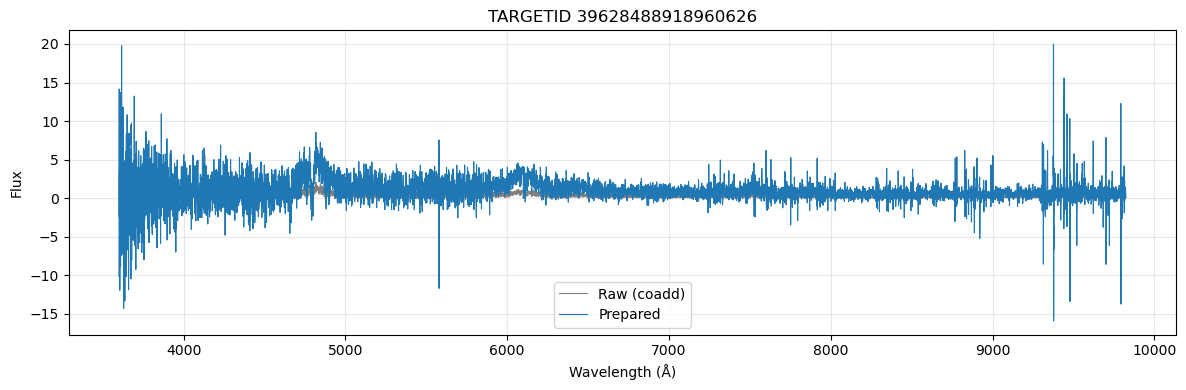

In [98]:
#just one spectrum
ipetal = petals[0]
sample_id = int(qso_tile_z['TARGETID'][0])

# raw coadd spectra
wave_raw, raw_dict = _load_raw_tile_spectra(tileid, ipetal, [sample_id])

# prepared spectra
spec, w, z, target_id, norm, zerr = prepare_spectra(tileid, ipetal, qso_tile_z)

# map prepared spectra by target id
prep_dict = {int(tid): spec[i].numpy() for i, tid in enumerate(target_id.numpy())}

# plot single target (no overlap)
plt.figure(figsize=(12, 4))
if sample_id in raw_dict:
    plt.plot(wave_raw, raw_dict[sample_id], color='gray', lw=0.8, label='Raw (coadd)')
if sample_id in prep_dict:
    plt.plot(desiQSO._wave_obs, prep_dict[sample_id], color='tab:blue', lw=0.8, label='Prepared')

plt.title(f'TARGETID {sample_id}')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

keep: 15 / 15


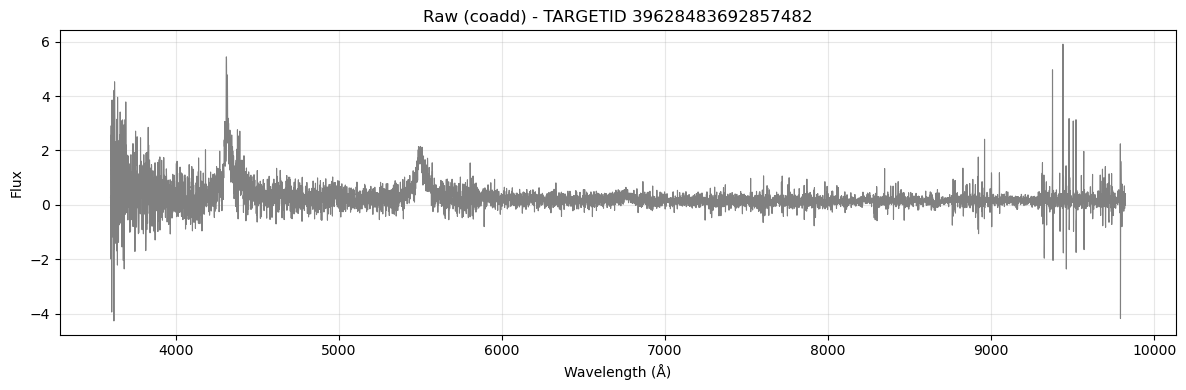

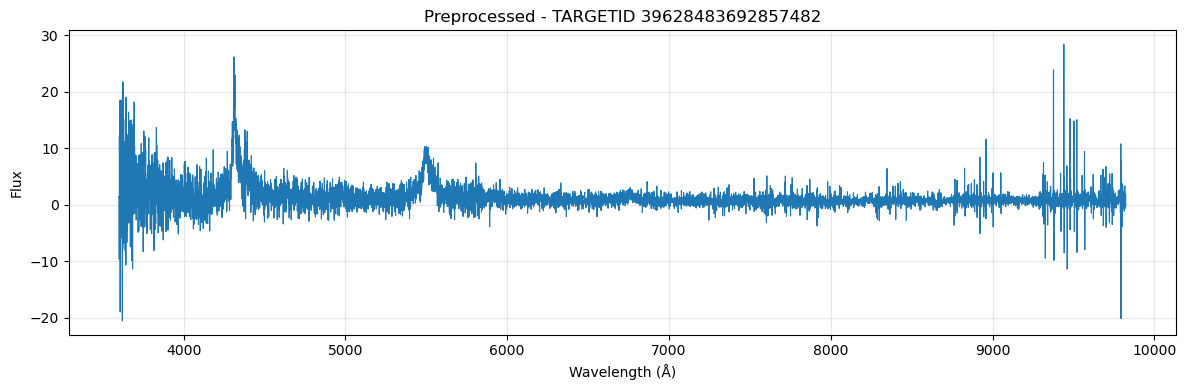

In [102]:
# just one spectrum
ipetal = petals[0]
sample_id = int(qso_tile_z['TARGETID'][2])

# raw coadd spectra
wave_raw, raw_dict = _load_raw_tile_spectra(tileid, ipetal, [sample_id])

# prepared spectra
spec, w, z, target_id, norm, zerr = prepare_spectra(tileid, ipetal, qso_tile_z)

# map prepared spectra by target id
prep_dict = {int(tid): spec[i].numpy() for i, tid in enumerate(target_id.numpy())}

# plot RAW only
plt.figure(figsize=(12, 4))
if sample_id in raw_dict:
    plt.plot(wave_raw, raw_dict[sample_id], color='gray', lw=0.8)
plt.title(f'Raw (coadd) - TARGETID {sample_id}')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# plot PREPARED only
plt.figure(figsize=(12, 4))
if sample_id in prep_dict:
    plt.plot(desiQSO._wave_obs, prep_dict[sample_id], color='tab:blue', lw=0.8)
plt.title(f'Preprocessed - TARGETID {sample_id}')
plt.xlabel('Wavelength (Å)')
plt.ylabel('Flux')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

keep: 15 / 15


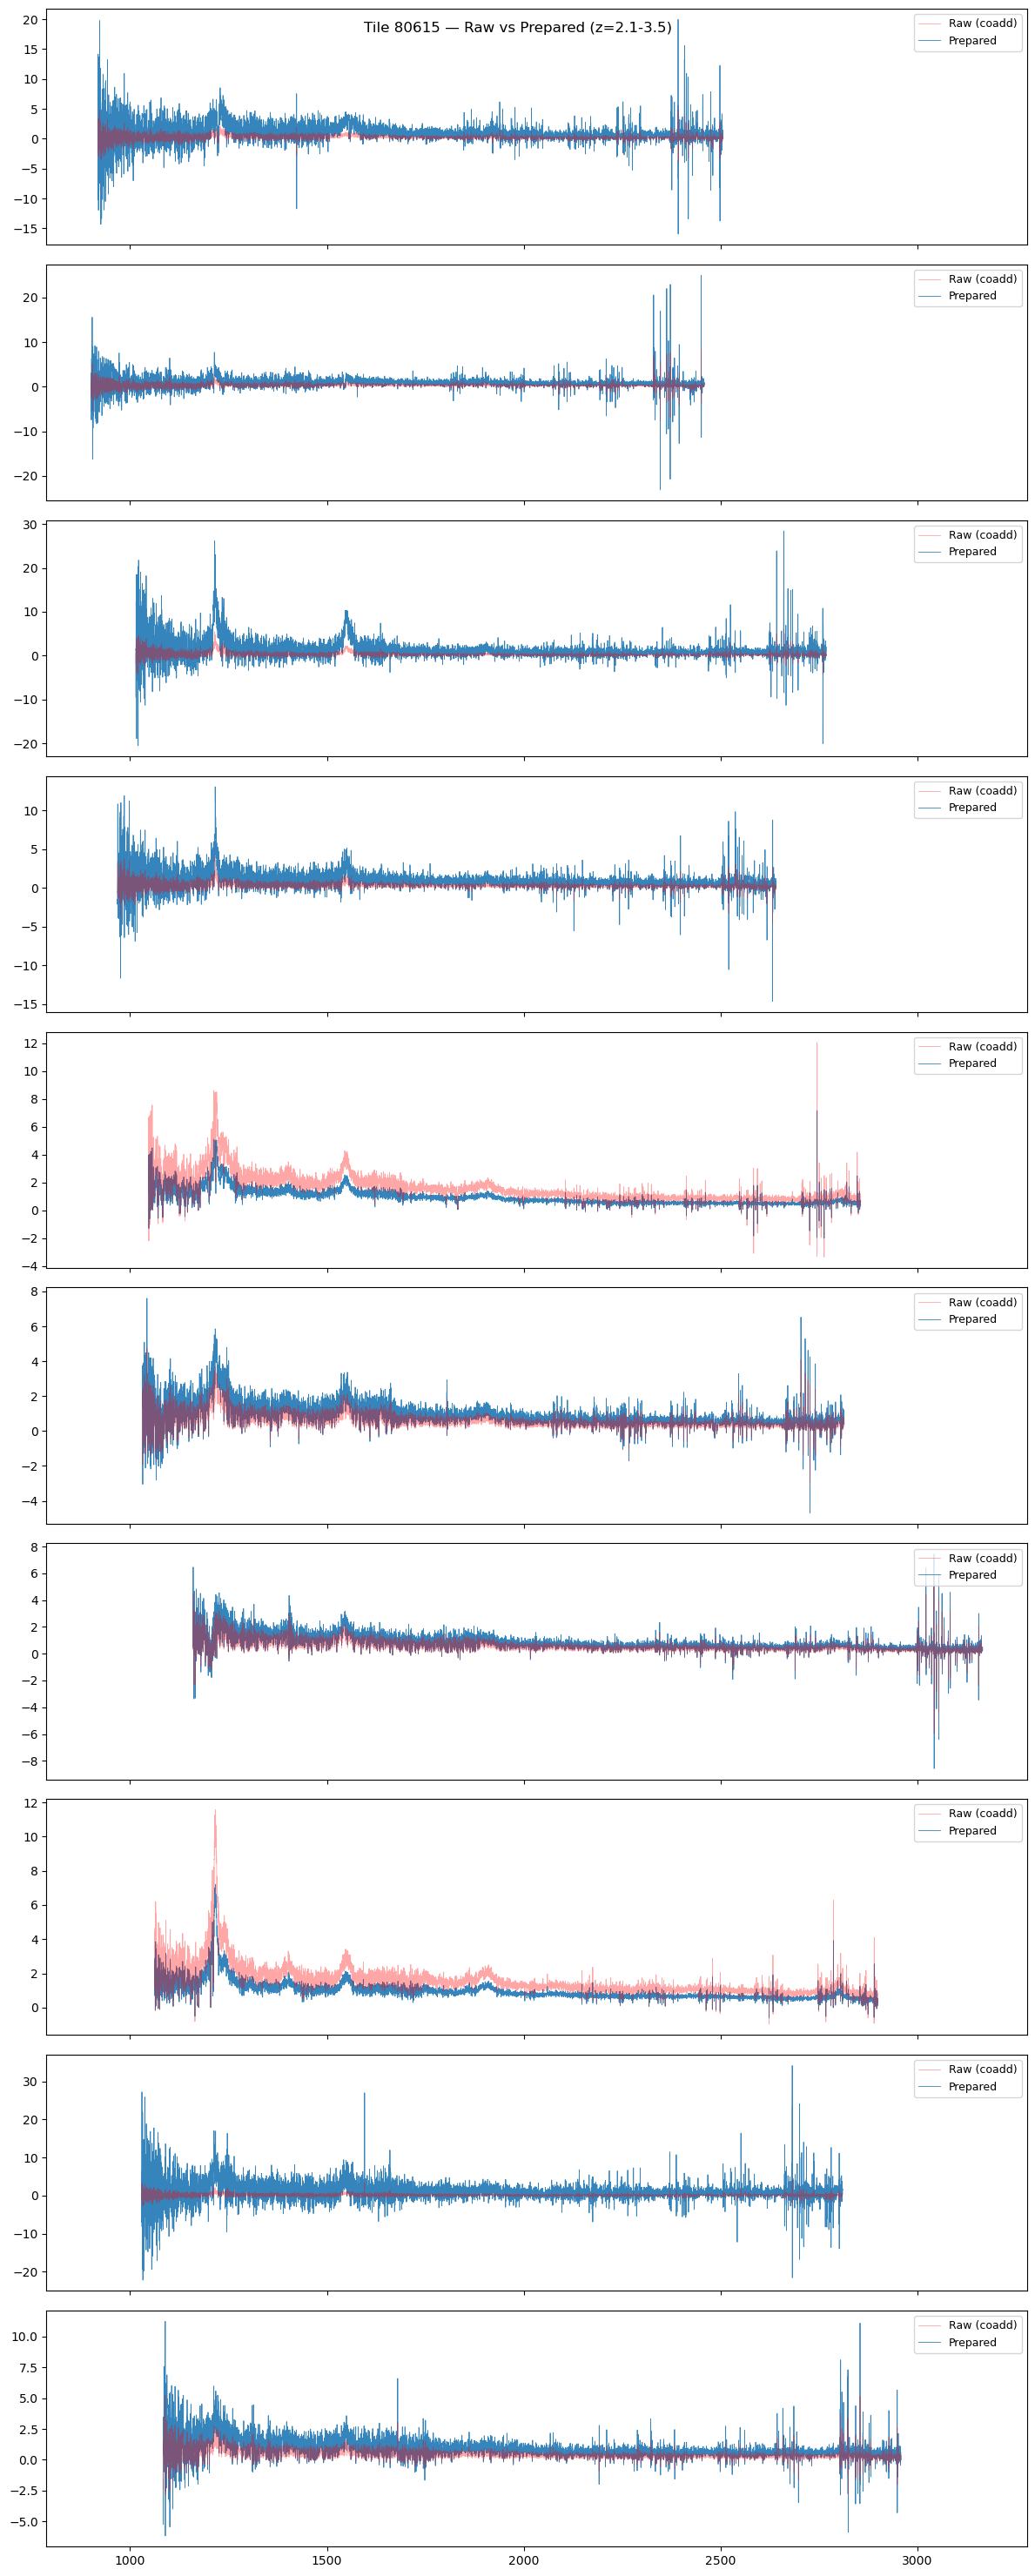

In [112]:
tileid = 80615
z_min, z_max = 2.1, 3.5
qso_tile_z = qsos[(qsos['TILEID'] == tileid) & (qsos['Z'] >= z_min) & (qsos['Z'] <= z_max)]
petals = np.unique(qso_tile_z['PETAL_LOC'])

ipetal = petals[0]
sample_ids = qso_tile_z['TARGETID'][:10].tolist()

# raw coadd spectra
wave_raw, raw_dict = _load_raw_tile_spectra(tileid, ipetal, sample_ids)

# prepared spectra
spec, w, z, target_id, norm, zerr = prepare_spectra(tileid, ipetal, qso_tile_z)

# map prepared spectra + redshift by target id
prep_dict = {int(tid): spec[i].numpy() for i, tid in enumerate(target_id.numpy())}
z_dict = {int(tid): float(z[i].numpy()) for i, tid in enumerate(target_id.numpy())}

# plot
fig, axes = plt.subplots(len(sample_ids), 1, figsize=(12, 3 * len(sample_ids)), sharex=True)
for ax, tid in zip(axes, sample_ids):
    if tid in raw_dict and tid in z_dict:
        z_i = z_dict[tid]
        ax.plot(
            wave_raw / (1 + z_i),
            raw_dict[tid],
            color='red',
            lw=0.6,
            alpha=0.35,
            zorder=3,
            label='Raw (coadd)'
        )
    if tid in prep_dict and tid in z_dict:
        z_i = z_dict[tid]
        ax.plot(
            desiQSO._wave_obs / (1 + z_i),
            prep_dict[tid],
            color='tab:blue',
            lw=0.6,
            alpha=0.9,
            zorder=2,
            label='Prepared'
        )

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right', fontsize=9)

fig.suptitle(f'Tile {tileid} — Raw vs Prepared (z={z_min}-{z_max})', fontsize=12)
plt.tight_layout()

In [104]:
# Example: print normalization details for one target
ipetal = petals[0]
sample_id = int(qso_tile_z['TARGETID'][0])

# Prepared spectra (normalized)
spec, w, z, target_id, norm, zerr = prepare_spectra(tileid, ipetal, qso_tile_z)

# Find index of this TARGETID in prepared outputs
tid_np = target_id.numpy()
idx = np.where(tid_np == sample_id)[0]
if len(idx) == 0:
    print(f"TARGETID {sample_id} not found in prepared spectra.")
else:
    i = idx[0]
    z_i = float(z[i].numpy())
    norm_i = float(norm[i].numpy())

    
    wave_rest = (desiQSO._wave_obs / (1.0 + z_i)).numpy()
    sel = (w[i].numpy() > 0) & (wave_rest > 1600) & (wave_rest < 1800)
# ...existing code...
    print(f"TARGETID: {sample_id}")
    print(f"z: {z_i:.6f}")
    print(f"norm (median in 1600–1800 Å): {norm_i:.6g}")
    print(f"window pixels: {sel.sum()}")

    # Show a few values from the window
    vals = spec[i].numpy()[sel]
    print("sample normalized flux values (first 10):", vals[:10])
# ...existing code...

keep: 15 / 15
TARGETID: 39628488918960626
z: 2.920026
norm (median in 1600–1800 Å): 0.242578
window pixels: 835
sample normalized flux values (first 10): [ 2.2161374   1.8928773   1.2818257   1.3733417   0.96291083 -0.1523409
  1.2537827   2.2972562   1.7433536   1.2266862 ]


# RUN SPENDERQ on spectra of TARGEID = 80615

Instantiating SpenderQ...
Running SpenderQ.eval() on full batch...


/Users/iemotoyuni/Desktop/SpenderQ/SpenderQ_Clone/SpenderQ/src/spenderq/lyalpha.py:32: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[above_lya] = (fmod_coarse[above_lya] - fobs_coarse[above_lya] > 3 * iobs_coarse[above_lya]**-0.5)
/Users/iemotoyuni/Desktop/SpenderQ/SpenderQ_Clone/SpenderQ/src/spenderq/lyalpha.py:106: RuntimeWarning: divide by zero encountered in divide
  dw = np.clip(8.0 / np.median(snr[wobs < wmax]), 4.0, 16.)
/Users/iemotoyuni/Desktop/SpenderQ/SpenderQ_Clone/SpenderQ/src/spenderq/lyalpha.py:36: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[lya_range] = (fmod_coarse[lya_range] - fobs_coarse[lya_range] > sigma_lya * iobs_coarse[lya_range]**-0.5)
/Users/iemotoyuni/Desktop/SpenderQ/SpenderQ_Clone/SpenderQ/src/spenderq/lyalpha.py:40: RuntimeWarning: divide by zero encountered in power
  is_absorb_coarse[lyb_range] = (fmod_coarse[lyb_range] - fobs_coarse[lyb_range] > sigma_lyb * iobs_coarse[lyb_range]**-0.5)


Latent shape: torch.Size([87, 10]), recon shape: (87, 9780)


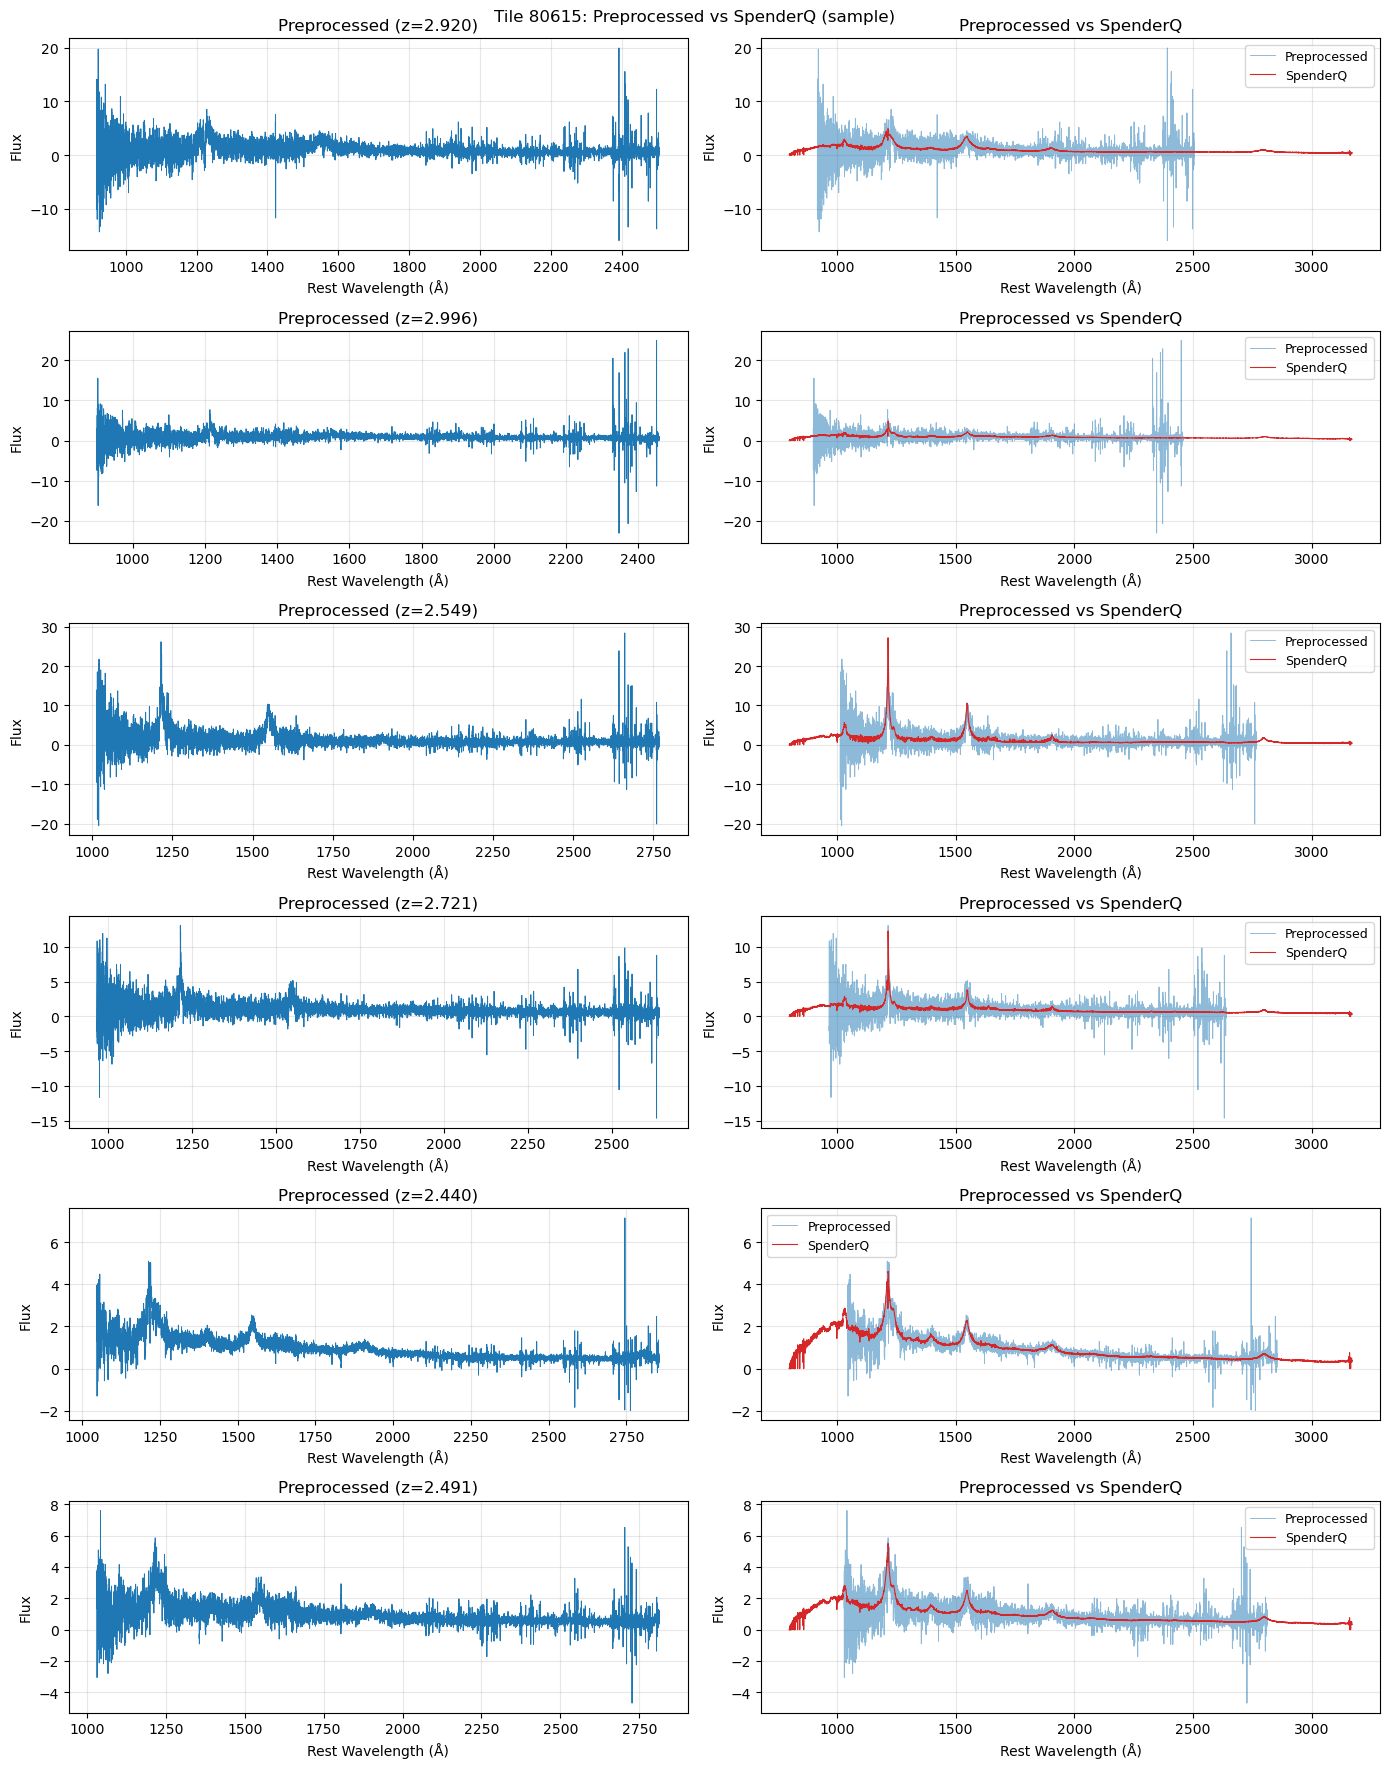

In [113]:

# ==== Run SpenderQ on all preprocessed spectra for tile 80615 and plot before/after ====
print('Instantiating SpenderQ...')
spender = SpenderQ('qso.dr1.hiz')

print('Running SpenderQ.eval() on full batch...')
try:
    s_all, recon_all = spender.eval(spec_all, w_all, z_all)
except IndexError as e:
    print(f'IndexError in Lyα absorption: {e}')
    print('Falling back to encode/decode without Lyα masking...')
    with torch.no_grad():
        spender.models[0][0].eval()
        s_all = spender.models[0][0].encode(spec_all)
        recon_all = np.array(spender.models[0][0].decode(s_all))

print(f'Latent shape: {s_all.shape}, recon shape: {recon_all.shape}')

# Plot a subset (e.g., first 6)
wave_recon = spender.wave_recon()
nplot = min(6, spec_all.shape[0])
fig, axes = plt.subplots(nplot, 2, figsize=(14, 3 * nplot), sharex=False)

if nplot == 1:
    axes = axes.reshape(1, -1)

for i in range(nplot):
    z_i = float(z_all[i].cpu().numpy())
    wave_rest = (desiQSO._wave_obs / (1.0 + z_i)).cpu().numpy()
    spec_i = spec_all[i].cpu().numpy()
    recon_i = recon_all[i]

    # Before (preprocessed, no SpenderQ)
    axes[i, 0].plot(wave_rest, spec_i, color='tab:blue', lw=0.7)
    axes[i, 0].set_title(f'Preprocessed (z={z_i:.3f})')
    axes[i, 0].set_xlabel('Rest Wavelength (Å)')
    axes[i, 0].set_ylabel('Flux')
    axes[i, 0].grid(alpha=0.3)

    # After (SpenderQ recon)
    axes[i, 1].plot(wave_rest, spec_i, color='tab:blue', lw=0.7, alpha=0.5, label='Preprocessed')
    axes[i, 1].plot(wave_recon, recon_i, color='tab:red', lw=0.8, label='SpenderQ')
    axes[i, 1].set_title('Preprocessed vs SpenderQ')
    axes[i, 1].set_xlabel('Rest Wavelength (Å)')
    axes[i, 1].set_ylabel('Flux')
    axes[i, 1].grid(alpha=0.3)
    axes[i, 1].legend(fontsize=9)

plt.suptitle('Tile 80615: Preprocessed vs SpenderQ (sample)', fontsize=12)
plt.tight_layout()
plt.show()
# ...existing code...